# Create Dummy Data


In [3]:
# JUPYTER CELL — Stage 1: Generate consecutive OHLCV data
import numpy as np
import pandas as pd

def make_consecutive_ohlcv(
    periods,
    start,
    freq,
    start_price,
    drift_per_bar,   # mean log-return per bar (upward drift)
    vol_per_bar,       # std of log-returns per bar (volatility)
    wick_frac,          # wick size factor relative to body/volatility
    vol_min, vol_max,
    seed
) -> pd.DataFrame:
    """Generate a consecutive OHLCV DataFrame where open[t] == close[t-1]."""
    rng = np.random.default_rng(seed)

    # Time index
    idx = pd.date_range(start, periods=periods, freq=freq)

    # Price path via log-returns ~ N(drift, vol)
    rets = rng.normal(loc=drift_per_bar, scale=vol_per_bar, size=periods)
    close = start_price * np.exp(np.cumsum(rets))

    # Consecutive opens
    open_ = np.empty(periods, dtype=float)
    open_[0] = start_price
    open_[1:] = close[:-1]

    # Wicks based on body and volatility
    body = np.abs(close - open_)
    wick_scale = wick_frac * (body + (vol_per_bar * 0.5 * close))
    up_wick = rng.random(periods) * wick_scale
    dn_wick = rng.random(periods) * wick_scale

    high = np.maximum(open_, close) + up_wick
    low  = np.minimum(open_, close) - dn_wick
    low = np.clip(low, 1e-9, None)  # keep prices positive

    # Integer volumes
    volume = rng.integers(low=vol_min, high=vol_max, size=periods)

    df = pd.DataFrame(
        {"open": open_, "high": high, "low": low, "close": close, "volume": volume},
        index=idx
    ).rename(columns=str.lower).sort_index()

    # Sanity: ensure consecutiveness
    assert np.allclose(df["open"].iloc[1:].values, df["close"].iloc[:-1].values), \
        "Consecutiveness failed: open[t] must equal close[t-1]."
    return df

# --- Build your OHLCV dataset (as requested) ---
df = make_consecutive_ohlcv(
    periods=5000,
    start="2022-01-03 09:30",
    freq="5min",
    start_price=100000.0,
    drift_per_bar=0.0005,
    vol_per_bar=0.02,
    wick_frac=0.5,
    vol_min=100, vol_max=5000,
    seed=None,
)

df.head(5)

,open,high,low,close,volume
2022-01-03 09:30:00,100000.000000,101057.466522,97803.478720,97871.466091,3077
2022-01-03 09:35:00,97871.466091,97992.715695,97330.153852,97829.592382,1884
2022-01-03 09:40:00,97829.592382,98019.279789,96967.029354,97526.361184,4729
2022-01-03 09:45:00,97526.361184,100000.769637,96401.918093,99390.956479,2543
2022-01-03 09:50:00,99390.956479,99414.737356,98413.931964,98935.716502,2289


# Draw Candleds

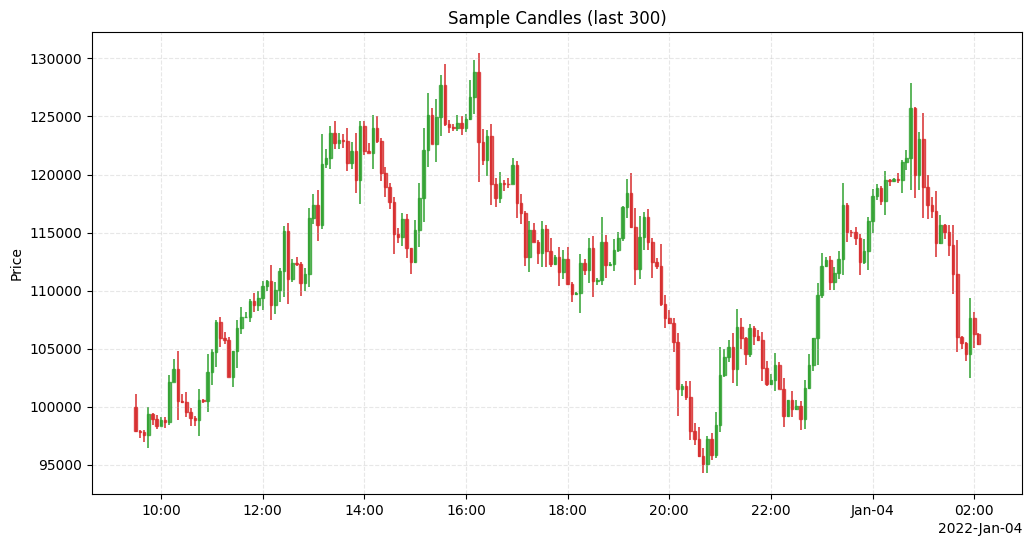

In [4]:
# JUPYTER CELL — Stage 2: Plot candles (line: high↔low, rectangle: open↔close)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_candles(
    df: pd.DataFrame,
    title: str = "Candlestick",
    n_last: int | None = 300,
    body_width: float = 0.6,     # fraction of bar spacing (0..1)
    wick_linewidth: float = 1.2  # wick width in points
):
    """Plot OHLC candles: a vertical line (low-high) and a rectangle (open-close)."""
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    required = {"open","high","low","close"}
    if not required.issubset(g.columns):
        raise ValueError(f"DataFrame must contain {sorted(required)}")

    if n_last is not None and n_last > 0:
        g = g.iloc[:n_last].copy()

    # Convert index to matplotlib date numbers
    x = mdates.date2num(pd.to_datetime(g.index).to_pydatetime())

    # Estimate bar spacing to size bodies
    dx = float(np.median(np.diff(x))) if len(x) > 1 else 1.0
    bw = np.clip(body_width, 0.0, 1.0) * dx

    o = g["open"].to_numpy(float)
    h = g["high"].to_numpy(float)
    l = g["low"].to_numpy(float)
    c = g["close"].to_numpy(float)

    up = c >= o
    dn = ~up
    up_color, dn_color = "#2ca02c", "#d62728"

    fig, ax = plt.subplots(figsize=(12, 6))

    # Wicks (match colors with bodies)
    ax.vlines(x[up], l[up], h[up], linewidth=wick_linewidth, color=up_color, alpha=0.9, zorder=1)
    ax.vlines(x[dn], l[dn], h[dn], linewidth=wick_linewidth, color=dn_color, alpha=0.9, zorder=1)

    # Bodies: bottom=min(open, close), height=abs(close-open)
    body_bottom = np.minimum(o, c)
    body_height = np.abs(c - o)
    ax.bar(x[up], body_height[up], bottom=body_bottom[up], width=bw, align="center",
           edgecolor=up_color, facecolor=up_color, alpha=0.75, zorder=2)
    ax.bar(x[dn], body_height[dn], bottom=body_bottom[dn], width=bw, align="center",
           edgecolor=dn_color, facecolor=dn_color, alpha=0.75, zorder=2)

    # Axis cosmetics
    ax.set_title(title)
    ax.set_ylabel("Price")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.xaxis_date()
    loc = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

    plt.show()

# Quick preview
plot_candles(df, title="Sample Candles (last 300)", n_last=200)


# Features

In [5]:
# JUPYTER CELL — feature: volprof_poc_dist_100 (robust)
FEATURE_CODE = "volprof_poc_dist_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Volume Profile POC distance (100)
    Description:
      Relative distance from the current close to the Point of Control (POC)
      over a 100-bar window; POC via weighted histogram mode (weights=volume).
    Formula / method (brief):
      For each window (size=100):
        - Weighted histogram of close (bins=50 over [min,max]).
        - POC := center of the max-weight bin.
        - dist := (close_t - POC) / close_t
    Input:
      df with columns open, high, low, close, volume (case-insensitive).
    Output:
      pd.Series (float), same index, name == FEATURE_CODE; initial NaNs allowed.
    Constraints:
      - No look-ahead. Uses only current/past data.
      - Numpy/Pandas only (loop over windows; reliable across pandas versions).
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    if not {"close","volume"}.issubset(g.columns):
        raise ValueError("DataFrame must contain 'close' and 'volume'.")

    c = g["close"].to_numpy(float)
    v = g["volume"].to_numpy(float)
    n = len(g); W = 100; BINS = 50

    level = np.full(n, np.nan, float)

    for i in range(W-1, n):
        cs = c[i-W+1:i+1]
        vs = v[i-W+1:i+1]
        m = np.isfinite(cs) & np.isfinite(vs)
        if m.sum() < 3:
            continue
        cs = cs[m]; vs = vs[m]
        pmin, pmax = cs.min(), cs.max()
        if not np.isfinite(pmin) or not np.isfinite(pmax) or pmax <= pmin:
            continue
        hist, edges = np.histogram(cs, bins=BINS, range=(pmin, pmax), weights=vs)
        if hist.size == 0 or np.all(hist <= 0):
            continue
        j = int(np.argmax(hist))
        level[i] = 0.5 * (edges[j] + edges[j+1])

    s = (c - level) / c
    s = pd.Series(s, index=g.index, dtype=float, name=FEATURE_CODE)
    return s


In [6]:
# JUPYTER CELL — feature: volprof_val_dist_100 (robust)
FEATURE_CODE = "volprof_val_dist_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Volume Profile VAL distance (100)
    Description:
      Relative distance from close to Value Area Low (VAL) ≈ weighted 15% quantile
      of close over a 100-bar window (weights=volume).
    Formula / method (brief):
      VAL := weighted_quantile(close, weights=volume, q=0.15)
      dist := (close_t - VAL) / close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    if not {"close","volume"}.issubset(g.columns):
        raise ValueError("DataFrame must contain 'close' and 'volume'.")

    def _wq(px: np.ndarray, w: np.ndarray, q: float) -> float:
        m = np.isfinite(px) & np.isfinite(w) & (w >= 0)
        px = px[m]; w = w[m]
        if px.size < 3 or w.sum() <= 0:
            return np.nan
        order = np.argsort(px)
        px = px[order]; w = w[order]
        csum = np.cumsum(w)
        thr = q * csum[-1]
        i = int(np.searchsorted(csum, thr, side="left"))
        i = min(max(i, 0), len(px)-1)
        return float(px[i])

    c = g["close"].to_numpy(float)
    v = g["volume"].to_numpy(float)
    n = len(g); W = 100

    level = np.full(n, np.nan, float)
    for i in range(W-1, n):
        cs = c[i-W+1:i+1]
        vs = v[i-W+1:i+1]
        level[i] = _wq(cs, vs, 0.15)

    s = (c - level) / c
    s = pd.Series(s, index=g.index, dtype=float, name=FEATURE_CODE)
    return s


In [7]:
# JUPYTER CELL — feature: volprof_vah_dist_100 (robust)
FEATURE_CODE = "volprof_vah_dist_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Volume Profile VAH distance (100)
    Description:
      Relative distance from close to Value Area High (VAH) ≈ weighted 85% quantile
      of close over a 100-bar window (weights=volume).
    Formula / method (brief):
      VAH := weighted_quantile(close, weights=volume, q=0.85)
      dist := (close_t - VAH) / close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    if not {"close","volume"}.issubset(g.columns):
        raise ValueError("DataFrame must contain 'close' and 'volume'.")

    def _wq(px: np.ndarray, w: np.ndarray, q: float) -> float:
        m = np.isfinite(px) & np.isfinite(w) & (w >= 0)
        px = px[m]; w = w[m]
        if px.size < 3 or w.sum() <= 0:
            return np.nan
        order = np.argsort(px)
        px = px[order]; w = w[order]
        csum = np.cumsum(w)
        thr = q * csum[-1]
        i = int(np.searchsorted(csum, thr, side="left"))
        i = min(max(i, 0), len(px)-1)
        return float(px[i])

    c = g["close"].to_numpy(float)
    v = g["volume"].to_numpy(float)
    n = len(g); W = 100

    level = np.full(n, np.nan, float)
    for i in range(W-1, n):
        cs = c[i-W+1:i+1]
        vs = v[i-W+1:i+1]
        level[i] = _wq(cs, vs, 0.85)

    s = (c - level) / c
    s = pd.Series(s, index=g.index, dtype=float, name=FEATURE_CODE)
    return s


In [8]:
# JUPYTER CELL — feature: range_high_dist_50
FEATURE_CODE = "range_high_dist_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Range High Distance (50)
    Description:
      Relative distance from the current close to the rolling 50-bar highest high.
      Positive values mean close is above the range-high (rare), negative values
      mean close is below the range-high (typical).
    Formula / method (brief):
      RH_t = max(high_{t-49..t})
      dist_t = (close_t - RH_t) / close_t
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, length == len(df),
      name == FEATURE_CODE. Initial NaNs from rolling windows are OK.
    Constraints:
      - No look-ahead (uses only current and past data).
      - Vectorized (rolling max).
      - Uses only numpy and pandas.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]  # normalize

    # Rolling 50-bar highest high (includes current bar)
    rh = g["high"].rolling(50, min_periods=50).max().astype(float)

    # Relative distance from range-high
    s = (g["close"].astype(float) - rh) / g["close"].astype(float)
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s

In [9]:
# JUPYTER CELL — feature: range_low_dist_50
FEATURE_CODE = "range_low_dist_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Range Low Distance (50)
    Description:
      Relative distance from the current close to the rolling 50-bar lowest low.
      Positive values mean close is above the range-low (typical), negative values
      mean close is below the range-low (rare).
    Formula / method (brief):
      RL_t = min(low_{t-49..t})
      dist_t = (close_t - RL_t) / close_t
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, length == len(df),
      name == FEATURE_CODE. Initial NaNs from rolling windows are OK.
    Constraints:
      - No look-ahead (uses only current and past data).
      - Vectorized (rolling min).
      - Uses only numpy and pandas.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]  # normalize

    # Rolling 50-bar lowest low (includes current bar)
    rl = g["low"].rolling(50, min_periods=50).min().astype(float)

    # Relative distance from range-low
    s = (g["close"].astype(float) - rl) / g["close"].astype(float)
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s

In [10]:
# JUPYTER CELL — feature: range_breakout_flag_50
FEATURE_CODE = "range_breakout_flag_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Range Breakout Flag (50)
    Description:
      Discrete flag indicating breakout vs. the previous 50 bars (excluding current):
        +1 if close_t > max(high_{t-50..t-1})  (up-breakout)
        -1 if close_t < min(low_{t-50..t-1})   (down-breakout)
         0 otherwise (inside the prior 50-bar range)
    Formula / method (brief):
      prev_high_t = max(high_{t-50..t-1}) = rolling_max(high, 50) on shifted series
      prev_low_t  = min(low_{t-50..t-1})  = rolling_min(low, 50) on shifted series
      flag_t = 1 if close_t > prev_high_t; -1 if close_t < prev_low_t; else 0
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (int), same index as df.index, length == len(df),
      name == FEATURE_CODE. Initial NaNs from rolling windows are OK (will map to 0).
    Constraints:
      - No look-ahead (uses only current and past data; window excludes current via shift).
      - Vectorized (rolling + numpy where).
      - Uses only numpy and pandas.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]  # normalize

    # Prior window (exclude current) via shift(1)
    prev_high = g["high"].shift(1).rolling(50, min_periods=50).max().astype(float)
    prev_low  = g["low"].shift(1).rolling(50, min_periods=50).min().astype(float)

    c = g["close"].astype(float)

    up_break   = c > prev_high
    down_break = c < prev_low

    # Map to {-1, 0, +1}; NaNs in prev_* yield False in comparisons -> 0
    flag = np.where(up_break, 1, np.where(down_break, -1, 0)).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s

In [11]:
# JUPYTER CELL — feature: channel_reg_upper_dist_50
FEATURE_CODE = "channel_reg_upper_dist_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Regression Channel — Upper Distance (50)
    Description:
      Relative distance from the current close to the UPPER regression channel line
      built on a 50-bar rolling linear regression of close vs. time. The channel
      uses the regression line ± 1×(residual_std). Here residual_std is approximated
      by sqrt( var_y * (1 - r^2) ), where r is the rolling correlation between time and close.
      (You can change the multiplier if you want wider/narrower channels.)
    Formula / method (brief):
      For each window W=50:
        - t = 0..N-1 (global index as float); y = close
        - slope = cov(t,y)/var(t)
          with cov, var computed via rolling means (no apply/loops).
        - intercept = mean(y) - slope*mean(t)
        - reg_line_t = slope * t + intercept
        - resid_std ≈ sqrt( var_y * (1 - r^2) ), r = cov / sqrt(var_t*var_y)
        - upper = reg_line_t + 1 * resid_std
        - dist = (close - upper) / close
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, name == FEATURE_CODE.
      Initial NaNs from rolling windows are OK.
    Constraints:
      - No look-ahead.
      - Vectorized with rolling means.
      - Numpy & pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    y = g["close"].astype(float)
    n = len(g)
    W = 50

    # time index as float (global positions 0..n-1)
    t = pd.Series(np.arange(n, dtype=float), index=g.index)

    # rolling means
    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    ty_mean = (t * y).rolling(W, min_periods=W).mean()
    t2_mean = (t * t).rolling(W, min_periods=W).mean()
    y2_mean = (y * y).rolling(W, min_periods=W).mean()

    cov_ty = ty_mean - t_mean * y_mean
    var_t  = t2_mean - t_mean * t_mean
    var_y  = y2_mean - y_mean * y_mean

    slope = cov_ty / var_t.replace(0.0, np.nan)
    intercept = y_mean - slope * t_mean
    reg_line = slope * t + intercept

    # correlation r and residual std ≈ sqrt(var_y * (1 - r^2))
    r = cov_ty / (np.sqrt(var_t) * np.sqrt(var_y))
    resid_std = np.sqrt(np.clip(var_y * (1.0 - r * r), a_min=0.0, a_max=None))

    # channel upper with multiplier m=1.0 (change if desired)
    m = 1.0
    upper = reg_line + m * resid_std

    s = (y - upper) / y
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s

In [12]:
# JUPYTER CELL — feature: channel_reg_lower_dist_50
FEATURE_CODE = "channel_reg_lower_dist_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Rolling Regression Channel — Lower Distance (50)
    Description:
      Relative distance from the current close to the LOWER regression channel line
      built on a 50-bar rolling linear regression of close vs. time. The channel
      uses the regression line ± 1×(residual_std), where residual_std ≈ sqrt(var_y*(1 - r^2)).
    Formula / method (brief):
      Same as the upper version, but:
        lower = reg_line_t - 1 * resid_std
        dist = (close - lower) / close
    Input/Output/Constraints:
      Same as channel_reg_upper_dist_50.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    y = g["close"].astype(float)
    n = len(g)
    W = 50

    t = pd.Series(np.arange(n, dtype=float), index=g.index)

    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    ty_mean = (t * y).rolling(W, min_periods=W).mean()
    t2_mean = (t * t).rolling(W, min_periods=W).mean()
    y2_mean = (y * y).rolling(W, min_periods=W).mean()

    cov_ty = ty_mean - t_mean * y_mean
    var_t  = t2_mean - t_mean * t_mean
    var_y  = y2_mean - y_mean * y_mean

    slope = cov_ty / var_t.replace(0.0, np.nan)
    intercept = y_mean - slope * t_mean
    reg_line = slope * t + intercept

    r = cov_ty / (np.sqrt(var_t) * np.sqrt(var_y))
    resid_std = np.sqrt(np.clip(var_y * (1.0 - r * r), a_min=0.0, a_max=None))

    m = 1.0
    lower = reg_line - m * resid_std

    s = (y - lower) / y
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s


In [13]:
# JUPYTER CELL — feature: trendline_touch_flag_100
FEATURE_CODE = "trendline_touch_flag_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Trendline Touch Flag (100)
    Description:
      Binary flag indicating whether the current close is "touching" the rolling
      regression trendline (close vs. time) over a 100-bar window, within a tolerance
      proportional to the window's residual standard deviation.
    Formula / method (brief):
      For each window W=100:
        - Compute slope/intercept of OLS(y~t); reg_line_t = slope*t + intercept
        - resid = close - reg_line_t
        - resid_std ≈ sqrt(var_y * (1 - r^2))
        - flag = 1 if |resid| <= tol_mult * resid_std  else 0
      Here tol_mult = 0.25 (change if you prefer).
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (int), values in {0,1}, same index as df.index, name == FEATURE_CODE.
    Constraints:
      - No look-ahead; vectorized with rolling means.
      - Numpy & pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    y = g["close"].astype(float)
    n = len(g)
    W = 100
    tol_mult = 0.25

    t = pd.Series(np.arange(n, dtype=float), index=g.index)

    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    ty_mean = (t * y).rolling(W, min_periods=W).mean()
    t2_mean = (t * t).rolling(W, min_periods=W).mean()
    y2_mean = (y * y).rolling(W, min_periods=W).mean()

    cov_ty = ty_mean - t_mean * y_mean
    var_t  = t2_mean - t_mean * t_mean
    var_y  = y2_mean - y_mean * y_mean

    slope = cov_ty / var_t.replace(0.0, np.nan)
    intercept = y_mean - slope * t_mean
    reg_line = slope * t + intercept

    # residual & residual std
    resid = y - reg_line
    r = cov_ty / (np.sqrt(var_t) * np.sqrt(var_y))
    resid_std = np.sqrt(np.clip(var_y * (1.0 - r * r), a_min=0.0, a_max=None))

    flag = (resid.abs() <= (tol_mult * resid_std)).astype(int)
    flag.name = FEATURE_CODE
    return flag


In [14]:
# JUPYTER CELL — feature: trendline_slope_100
FEATURE_CODE = "trendline_slope_100"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Trendline Slope (100)
    Description:
      Rolling OLS slope of close vs. time over a 100-bar window. This is the same
      idea as reg_lin_slope_W, but with W=100; it measures the per-bar trend
      (positive uptrend, negative downtrend).
    Formula / method (brief):
      slope_t = cov(t,y) / var(t), where cov/var computed via rolling means.
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, name == FEATURE_CODE.
    Constraints:
      - No look-ahead; vectorized with rolling means.
      - Numpy & pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    y = g["close"].astype(float)
    n = len(g)
    W = 100

    t = pd.Series(np.arange(n, dtype=float), index=g.index)

    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    cov = (t * y).rolling(W, min_periods=W).mean() - t_mean * y_mean
    var = (t * t).rolling(W, min_periods=W).mean() - t_mean * t_mean

    slope = cov / var.replace(0.0, np.nan)
    slope = slope.astype(float)
    slope.name = FEATURE_CODE
    return slope


In [15]:
# JUPYTER CELL — feature: pivot_classic_pp_dist_1d
FEATURE_CODE = "pivot_classic_pp_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot Point distance (previous day)
    Description:
      Relative distance from the current close to the prior day's Classic Pivot Point (PP).
      PP_prev_day = (H_prev + L_prev + C_prev) / 3, computed from the previous trading day.
    Formula / method (brief):
      - Aggregate intraday into daily H/L/C via groupby(normalized date).
      - Shift by 1 day to avoid look-ahead.
      - PP = (H_prev + L_prev + C_prev)/3
      - dist = (close_t - PP_for_today)/close_t
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (float), same index as df.index, name == FEATURE_CODE.
      First day(s) will be NaN (no prior day).
    Constraints:
      - No look-ahead (uses prior day levels only).
      - Vectorized (groupby + map).
      - Uses numpy and pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]  # normalize
    days = g.index.normalize()

    # Daily OHLC (based on intraday)
    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )

    # Previous-day pivots
    daily_prev = daily.shift(1)
    pp_daily = (daily_prev["high"] + daily_prev["low"] + daily_prev["close"]) / 3.0

    # Map each intraday bar's day -> that day's PP (from previous day)
    pp_intraday = pd.Series(pd.Index(days).map(pp_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - pp_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s

In [16]:
# JUPYTER CELL — feature: pivot_classic_r1_dist_1d
FEATURE_CODE = "pivot_classic_r1_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot R1 distance (previous day)
    Description:
      Relative distance from close to prior day's Classic R1.
      R1_prev = 2*PP_prev - L_prev, where PP_prev = (H_prev+L_prev+C_prev)/3.
    Formula / method (brief):
      - Daily OHLC from intraday; shift by 1 to get prior day.
      - Compute PP_prev, then R1_prev.
      - dist = (close_t - R1_today)/close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    days = g.index.normalize()

    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )
    dprev = daily.shift(1)
    pp = (dprev["high"] + dprev["low"] + dprev["close"]) / 3.0
    r1_daily = 2.0 * pp - dprev["low"]

    r1_intraday = pd.Series(pd.Index(days).map(r1_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - r1_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s


In [17]:
# JUPYTER CELL — feature: pivot_classic_r2_dist_1d
FEATURE_CODE = "pivot_classic_r2_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot R2 distance (previous day)
    Description:
      Relative distance from close to prior day's Classic R2.
      R2_prev = PP_prev + (H_prev - L_prev), where PP_prev = (H_prev+L_prev+C_prev)/3.
    Formula / method (brief):
      - Daily OHLC from intraday; shift by 1.
      - Compute PP_prev, then R2_prev.
      - dist = (close_t - R2_today)/close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    days = g.index.normalize()

    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )
    dprev = daily.shift(1)
    pp = (dprev["high"] + dprev["low"] + dprev["close"]) / 3.0
    r2_daily = pp + (dprev["high"] - dprev["low"])

    r2_intraday = pd.Series(pd.Index(days).map(r2_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - r2_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s


In [18]:
# JUPYTER CELL — feature: pivot_classic_s1_dist_1d
FEATURE_CODE = "pivot_classic_s1_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot S1 distance (previous day)
    Description:
      Relative distance from close to prior day's Classic S1.
      S1_prev = 2*PP_prev - H_prev, where PP_prev = (H_prev+L_prev+C_prev)/3.
    Formula / method (brief):
      - Daily OHLC from intraday; shift by 1.
      - Compute PP_prev, then S1_prev.
      - dist = (close_t - S1_today)/close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    days = g.index.normalize()

    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )
    dprev = daily.shift(1)
    pp = (dprev["high"] + dprev["low"] + dprev["close"]) / 3.0
    s1_daily = 2.0 * pp - dprev["high"]

    s1_intraday = pd.Series(pd.Index(days).map(s1_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - s1_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s


In [19]:
# JUPYTER CELL — feature: pivot_classic_s2_dist_1d
FEATURE_CODE = "pivot_classic_s2_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Classic Pivot S2 distance (previous day)
    Description:
      Relative distance from close to prior day's Classic S2.
      S2_prev = PP_prev - (H_prev - L_prev), where PP_prev = (H_prev+L_prev+C_prev)/3.
    Formula / method (brief):
      - Daily OHLC from intraday; shift by 1.
      - Compute PP_prev, then S2_prev.
      - dist = (close_t - S2_today)/close_t
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    days = g.index.normalize()

    daily = g.assign(__day=days).groupby("__day").agg(
        high=("high", "max"),
        low=("low", "min"),
        close=("close", "last"),
    )
    dprev = daily.shift(1)
    pp = (dprev["high"] + dprev["low"] + dprev["close"]) / 3.0
    s2_daily = pp - (dprev["high"] - dprev["low"])

    s2_intraday = pd.Series(pd.Index(days).map(s2_daily), index=g.index, dtype=float)

    s = (g["close"].astype(float) - s2_intraday) / g["close"].astype(float)
    s.name = FEATURE_CODE
    return s


In [20]:
# JUPYTER CELL — feature: mom_rsi_div_flag_14_5
FEATURE_CODE = "mom_rsi_div_flag_14_5"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    RSI Divergence Flag (RSI-14, lookback 5)
    Description:
      Flags simple bullish/bearish divergences between price and RSI:
        +1 (bullish): price makes a lower low vs prior 5 bars while RSI does NOT make a lower low.
        -1 (bearish): price makes a higher high vs prior 5 bars while RSI does NOT make a higher high.
         0 otherwise.
      (This is a lightweight, vectorized approximation of swing-based divergences.)
    Formula / method (brief, cite if needed):
      - RSI(14) via Wilder smoothing:
          gain = max(diff(close), 0), loss = max(-diff(close), 0)
          avg_gain = ewm(gain, alpha=1/14), avg_loss = ewm(loss, alpha=1/14)
          RS = avg_gain/avg_loss; RSI = 100 - 100/(1+RS)
      - With lookback L=5:
          prev_high  = rolling_max(close.shift(1), L)
          prev_low   = rolling_min(close.shift(1), L)
          prev_rsi_hi = rolling_max(RSI.shift(1), L)
          prev_rsi_lo = rolling_min(RSI.shift(1), L)
        bearish_div = (close > prev_high) & (RSI <= prev_rsi_hi - eps)
        bullish_div = (close < prev_low)  & (RSI >= prev_rsi_lo + eps)
      - flag = +1 if bullish_div, -1 if bearish_div, else 0
    Input:
      df: DataFrame with DatetimeIndex (ascending), columns:
           open, high, low, close, volume (case-insensitive)
    Output:
      pd.Series (int), values in {-1,0,+1}, same index as df.index, name == FEATURE_CODE.
      Initial NaNs from rolling windows are OK (mapped to 0 by comparisons).
    Constraints:
      - No look-ahead (all comparisons use shifted/rolling past data).
      - Vectorized; numpy and pandas only.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    close = g["close"].astype(float)
    delta = close.diff()

    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    alpha = 1.0 / 14.0
    avg_gain = gain.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    avg_loss = loss.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    rs = avg_gain / avg_loss.replace(0.0, np.nan)
    rsi = 100.0 - 100.0 / (1.0 + rs)
    rsi = rsi.clip(0.0, 100.0)

    L = 5
    prev_high   = g["close"].shift(1).rolling(L, min_periods=L).max()
    prev_low    = g["close"].shift(1).rolling(L, min_periods=L).min()
    prev_rsi_hi = rsi.shift(1).rolling(L, min_periods=L).max()
    prev_rsi_lo = rsi.shift(1).rolling(L, min_periods=L).min()

    eps = 0.1  # tiny tolerance
    bearish = (close > prev_high) & (rsi <= (prev_rsi_hi - eps))
    bullish = (close < prev_low)  & (rsi >= (prev_rsi_lo + eps))

    flag = np.where(bullish, 1, np.where(bearish, -1, 0)).astype(int)
    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [21]:
# JUPYTER CELL — feature: trend_sma_cross_flag_5_20
FEATURE_CODE = "trend_sma_cross_flag_5_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    SMA Crossover Flag (5 vs 20)
    Description:
      Discrete flag for moving-average crossovers:
        +1 when SMA(5) crosses ABOVE SMA(20) at current bar,
        -1 when SMA(5) crosses BELOW SMA(20) at current bar,
         0 otherwise.
    Formula / method (brief):
      s5  = SMA(close, 5), s20 = SMA(close, 20)
      d   = s5 - s20
      cross_up   if d>0 and d.shift(1)<=0
      cross_down if d<0 and d.shift(1)>=0
      flag = +1/-1/0
    Input / Output / Constraints:
      As per base structure; vectorized; no look-ahead.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    s5  = g["close"].rolling(5,  min_periods=5).mean()
    s20 = g["close"].rolling(20, min_periods=20).mean()
    d = s5 - s20

    cross_up   = (d > 0) & (d.shift(1) <= 0)
    cross_down = (d < 0) & (d.shift(1) >= 0)

    flag = np.where(cross_up, 1, np.where(cross_down, -1, 0)).astype(int)
    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [22]:
# JUPYTER CELL — feature: ichimoku_tenkan_dist_9
FEATURE_CODE = "ichimoku_tenkan_dist_9"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Tenkan Distance (9)
    Description:
      Relative distance from close to Tenkan-sen over 9 bars.
      Tenkan(9) = (rolling_high_9 + rolling_low_9) / 2.
    Formula / method (brief):
      hi9 = rolling max(high, 9); lo9 = rolling min(low, 9)
      tenkan = (hi9 + lo9)/2
      dist = (close - tenkan)/close
    Input/Output/Constraints:
      Standard; no look-ahead; vectorized.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi9 = g["high"].rolling(9, min_periods=9).max()
    lo9 = g["low"].rolling(9, min_periods=9).min()
    tenkan = (hi9 + lo9) / 2.0

    s = (g["close"].astype(float) - tenkan) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [23]:
# JUPYTER CELL — feature: ichimoku_kijun_dist_26
FEATURE_CODE = "ichimoku_kijun_dist_26"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Kijun Distance (26)
    Description:
      Relative distance from close to Kijun-sen over 26 bars.
      Kijun(26) = (rolling_high_26 + rolling_low_26) / 2.
    Formula:
      hi26 = rolling max(high,26); lo26 = rolling min(low,26)
      kijun = (hi26 + lo26)/2
      dist = (close - kijun)/close
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi26 = g["high"].rolling(26, min_periods=26).max()
    lo26 = g["low"].rolling(26, min_periods=26).min()
    kijun = (hi26 + lo26) / 2.0

    s = (g["close"].astype(float) - kijun) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [24]:
# JUPYTER CELL — feature: ichimoku_span_a_dist_52
FEATURE_CODE = "ichimoku_span_a_dist_52"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Senkou Span A Distance (lag-aligned)
    Description:
      Relative distance from close to Senkou Span A, aligned to current bar without look-ahead.
      Standard Span A is (Tenkan+Kijun)/2 shifted 26 bars forward. To avoid look-ahead,
      we use the unshifted value (equivalently, the standard Span A shifted BACK by 26),
      which depends only on past data.
    Formula / method (brief):
      tenkan = (max(high,9) + min(low,9))/2
      kijun  = (max(high,26)+ min(low,26))/2
      spanA_unshifted = (tenkan + kijun)/2
      dist = (close - spanA_unshifted)/close
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi9  = g["high"].rolling(9,  min_periods=9 ).max()
    lo9  = g["low"] .rolling(9,  min_periods=9 ).min()
    tenk = (hi9 + lo9) / 2.0

    hi26 = g["high"].rolling(26, min_periods=26).max()
    lo26 = g["low"] .rolling(26, min_periods=26).min()
    kij  = (hi26 + lo26) / 2.0

    span_a = (tenk + kij) / 2.0  # lag-aligned (no forward shift)
    s = (g["close"].astype(float) - span_a) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [25]:
# JUPYTER CELL — feature: ichimoku_span_b_dist_52
FEATURE_CODE = "ichimoku_span_b_dist_52"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Senkou Span B Distance (lag-aligned, 52)
    Description:
      Relative distance from close to Senkou Span B over 52 bars, aligned to current bar
      without look-ahead. Standard Span B = (max(high,52)+min(low,52))/2 shifted 26 forward;
      here we use the unshifted value (equivalently, standard Span B shifted BACK 26),
      which uses only past data at each row.
    Formula:
      hi52 = rolling max(high,52); lo52 = rolling min(low,52)
      spanB_unshifted = (hi52 + lo52)/2
      dist = (close - spanB_unshifted)/close
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi52 = g["high"].rolling(52, min_periods=52).max()
    lo52 = g["low"] .rolling(52, min_periods=52).min()
    span_b = (hi52 + lo52) / 2.0

    s = (g["close"].astype(float) - span_b) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [26]:
# JUPYTER CELL — feature: ichimoku_cloud_thickness_52
FEATURE_CODE = "ichimoku_cloud_thickness_52"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Ichimoku Cloud Thickness (lag-aligned, 52)
    Description:
      Normalized thickness of the Ichimoku cloud at the current bar (no look-ahead),
      defined as |SpanA - SpanB| / close. Both spans are the lag-aligned versions:
        SpanA = (Tenkan + Kijun)/2  (unshifted)
        SpanB = (max(high,52) + min(low,52))/2  (unshifted)
    Formula:
      tenkan(9), kijun(26), spanA=(tenkan+kijun)/2; spanB=(hi52+lo52)/2
      thickness = abs(spanA - spanB)/close
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    hi9  = g["high"].rolling(9,  min_periods=9 ).max()
    lo9  = g["low"] .rolling(9,  min_periods=9 ).min()
    tenk = (hi9 + lo9) / 2.0

    hi26 = g["high"].rolling(26, min_periods=26).max()
    lo26 = g["low"] .rolling(26, min_periods=26).min()
    kij  = (hi26 + lo26) / 2.0

    span_a = (tenk + kij) / 2.0
    hi52 = g["high"].rolling(52, min_periods=52).max()
    lo52 = g["low"] .rolling(52, min_periods=52).min()
    span_b = (hi52 + lo52) / 2.0

    thickness = (span_a - span_b).abs() / g["close"].astype(float)
    thickness = thickness.astype(float)
    thickness.name = FEATURE_CODE
    return thickness


In [27]:
# JUPYTER CELL — feature: band_gauss_upper_dist_20_2
FEATURE_CODE = "band_gauss_upper_dist_20_2"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Gaussian/Bollinger Upper Band Distance (20, 2σ)
    Description:
      Relative distance from close to the upper Gaussian band:
        upper = SMA(close,20) + 2 * std(close,20, ddof=0)
      (This is the common Bollinger upper band with 20 periods, 2 standard deviations.)
    Formula / method (brief):
      ma20 = rolling mean(close,20); sd20 = rolling std(close,20) with ddof=0
      upper = ma20 + 2*sd20
      dist = (close - upper)/close
    Input/Output/Constraints:
      Standard; vectorized; no look-ahead.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    ma20 = g["close"].rolling(20, min_periods=20).mean()
    sd20 = g["close"].rolling(20, min_periods=20).std(ddof=0)  # population std
    upper = ma20 + 2.0 * sd20

    s = (g["close"].astype(float) - upper) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [28]:
# JUPYTER CELL — feature: regime_range_flag_adx_14
FEATURE_CODE = "regime_range_flag_adx_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Range Flag via ADX (14)
    Description:
      Flags 1 when ADX(14) < 20 (weak trend), suggesting a ranging/sideways regime. Else 0.
    Method:
      Same ADX pipeline as above; only final condition changes to (ADX < 20).
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)

    up_move   = h.diff()
    down_move = -l.diff()

    plus_dm  = np.where((up_move > down_move) & (up_move > 0),  up_move,  0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=g.index)
    minus_dm = pd.Series(minus_dm, index=g.index)

    tr = pd.concat([(h - l), (h - c.shift(1)).abs(), (l - c.shift(1)).abs()], axis=1).max(axis=1)

    alpha = 1/14
    tr_sm     = tr.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    plus_sm   = plus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    minus_sm  = minus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    plus_di  = 100.0 * (plus_sm  / tr_sm.replace(0.0, np.nan))
    minus_di = 100.0 * (minus_sm / tr_sm.replace(0.0, np.nan))

    dx = 100.0 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0.0, np.nan)
    adx = dx.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    flag = (adx < 20.0).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [29]:
# JUPYTER CELL — feature: regime_trend_down_flag_adx_14
FEATURE_CODE = "regime_trend_down_flag_adx_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Downtrend Flag via ADX (14)
    Description:
      Flags 1 when ADX(14) >= 20 and -DI > +DI (trend strength + negative direction). Else 0.
    Method:
      Same ADX pipeline as the uptrend version, final condition reversed.
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)

    up_move   = h.diff()
    down_move = -l.diff()

    plus_dm  = np.where((up_move > down_move) & (up_move > 0),  up_move,  0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=g.index)
    minus_dm = pd.Series(minus_dm, index=g.index)

    tr = pd.concat([(h - l), (h - c.shift(1)).abs(), (l - c.shift(1)).abs()], axis=1).max(axis=1)

    alpha = 1/14
    tr_sm     = tr.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    plus_sm   = plus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    minus_sm  = minus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    plus_di  = 100.0 * (plus_sm  / tr_sm.replace(0.0, np.nan))
    minus_di = 100.0 * (minus_sm / tr_sm.replace(0.0, np.nan))

    dx = 100.0 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0.0, np.nan)
    adx = dx.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    flag = ((adx >= 20.0) & (minus_di > plus_di)).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [30]:
# JUPYTER CELL — feature: regime_trend_up_flag_adx_14
FEATURE_CODE = "regime_trend_up_flag_adx_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Uptrend Flag via ADX (14)
    Description:
      Flags 1 when ADX(14) >= 20 and +DI > -DI (trend strength + positive direction). Else 0.
    Method (Wilder approximations using EWM as proxy):
      +DM = max(high_t - high_{t-1}, 0) if > (low_{t-1} - low_t) else 0
      -DM = max(low_{t-1} - low_t, 0)  if > (high_t - high_{t-1}) else 0
      TR  = max(high-low, |high-close_{t-1}|, |low-close_{t-1}|)
      Smooth with EWM(alpha=1/14, adjust=False, min_periods=14)
      +DI = 100 * (+DM_sm / TR_sm); -DI = 100 * (-DM_sm / TR_sm)
      DX  = 100 * |(+DI - -DI)| / (+DI + -DI)
      ADX = EWM(DX, alpha=1/14, adjust=False, min_periods=14)
      flag = 1 if (ADX>=20) & (+DI > -DI) else 0
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)

    up_move   = h.diff()
    down_move = -l.diff()

    plus_dm  = np.where((up_move > down_move) & (up_move > 0),  up_move,  0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=g.index)
    minus_dm = pd.Series(minus_dm, index=g.index)

    tr = pd.concat([(h - l), (h - c.shift(1)).abs(), (l - c.shift(1)).abs()], axis=1).max(axis=1)

    alpha = 1/14
    tr_sm     = tr.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    plus_sm   = plus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()
    minus_sm  = minus_dm.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    plus_di  = 100.0 * (plus_sm  / tr_sm.replace(0.0, np.nan))
    minus_di = 100.0 * (minus_sm / tr_sm.replace(0.0, np.nan))

    dx = 100.0 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0.0, np.nan)
    adx = dx.ewm(alpha=alpha, adjust=False, min_periods=14).mean()

    flag = ((adx >= 20.0) & (plus_di > minus_di)).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [31]:
# JUPYTER CELL — feature: regime_trend_down_flag_slopeatr_50_14
FEATURE_CODE = "regime_trend_down_flag_slope_50_atr_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Downtrend Flag via Regression Slope normalized by ATR (W=50, ATR=14)
    Description:
      Flags 1 when rolling OLS slope(close~time,50) normalized by ATR(14) is below −k (k=0.05),
      implying a persistent downward drift vs. volatility. Else 0.
    Method:
      Same slope/ATR as the uptrend version.
      z = slope50 / atr14
      flag = 1 if z <= -k else 0
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    y = g["close"].astype(float)
    n = len(g); W = 50

    t = pd.Series(np.arange(n, dtype=float), index=g.index)
    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    cov = (t*y).rolling(W, min_periods=W).mean() - t_mean*y_mean
    var = (t*t).rolling(W, min_periods=W).mean() - t_mean*t_mean
    slope = cov / var.replace(0.0, np.nan)

    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)
    tr = pd.concat([
        (h - l),
        (h - c.shift(1)).abs(),
        (l - c.shift(1)).abs()
    ], axis=1).max(axis=1)
    atr14 = tr.ewm(alpha=1/14, adjust=False, min_periods=14).mean()

    z = slope / atr14.replace(0.0, np.nan)
    k = 0.05
    flag = (z <= -k).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [32]:
# JUPYTER CELL — feature: regime_trend_up_flag_slopeatr_50_14
FEATURE_CODE = "regime_trend_up_flag_slope_50_atr_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Uptrend Flag via Regression Slope normalized by ATR (W=50, ATR=14)
    Description:
      Flags 1 when rolling OLS slope(close~time,50) normalized by ATR(14) is above +k (k=0.05 by default),
      implying a persistent upward drift vs. recent volatility. Else 0.
    Method:
      slope50 = cov(t,y)/var(t) using rolling means (y=close, t=0..N-1)
      atr14 = Wilder ATR(14) on high/low/close
      z = slope50 / atr14
      flag = 1 if z >= k else 0   (k = 0.05)
    Notes:
      - Units: slope is price/bar; dividing by ATR (price units) yields per-bar in ATR units.
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    y = g["close"].astype(float)
    n = len(g); W = 50

    # Rolling OLS slope
    t = pd.Series(np.arange(n, dtype=float), index=g.index)
    t_mean = t.rolling(W, min_periods=W).mean()
    y_mean = y.rolling(W, min_periods=W).mean()
    cov = (t*y).rolling(W, min_periods=W).mean() - t_mean*y_mean
    var = (t*t).rolling(W, min_periods=W).mean() - t_mean*t_mean
    slope = cov / var.replace(0.0, np.nan)

    # ATR(14) — Wilder
    h, l, c = g["high"].astype(float), g["low"].astype(float), g["close"].astype(float)
    tr = pd.concat([
        (h - l),
        (h - c.shift(1)).abs(),
        (l - c.shift(1)).abs()
    ], axis=1).max(axis=1)
    atr14 = tr.ewm(alpha=1/14, adjust=False, min_periods=14).mean()

    z = slope / atr14.replace(0.0, np.nan)
    k = 0.05
    flag = (z >= k).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [33]:
# JUPYTER CELL — feature: regime_range_flag_bb_20_q20
FEATURE_CODE = "regime_range_flag_bb_20_q20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime: Range Flag via Bollinger Bandwidth (BB(20), below 20th percentile over 120 bars)
    Description:
      Flags 1 when the 20-bar Bollinger Bandwidth is unusually low (<= rolling 20% quantile over 120 bars),
      which often corresponds to ranging/sideways regimes. Otherwise 0.
    Method:
      ma20 = SMA(close,20); sd20 = STD(close,20, ddof=0)
      bbw20 = (upper - lower) / ma20 = (2*sd20 + 2*sd20) / ma20 = 4*sd20/ma20
      thresh = rolling_quantile(bbw20, window=120, q=0.20) (using pandas.Series.quantile on rolling)
      flag = 1 if bbw20 <= thresh else 0
    Constraints:
      - No look-ahead (threshold is from rolling past+current window).
      - Vectorized; numpy & pandas only.
    """
    g = df.copy(); g.columns = [str(c).lower() for c in g.columns]
    c = g["close"].astype(float)

    ma20 = c.rolling(20, min_periods=20).mean()
    sd20 = c.rolling(20, min_periods=20).std(ddof=0)
    bbw20 = (4.0 * sd20) / ma20.replace(0.0, np.nan)  # normalized width

    # Rolling 20th percentile over 120 bars
    # Note: rolling(...).quantile(q) is vectorized and avoids look-ahead.
    thresh = bbw20.rolling(120, min_periods=120).quantile(0.20, interpolation="linear")

    flag = (bbw20 <= thresh).astype(int).fillna(0)
    s = pd.Series(flag.values, index=g.index, name=FEATURE_CODE)
    return s


In [34]:
# JUPYTER CELL — feature: band_gauss_lower_dist_20_2
FEATURE_CODE = "band_gauss_lower_dist_20_2"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Gaussian Lower Band Distance (20, 2σ)
    Description:
      Relative distance from close to the lower Gaussian band:
        lower = SMA(close,20) - 2 * std(close,20, ddof=0)
      (This is the common Bollinger lower band with 20 periods, 2 standard deviations.)
    Formula / method (brief):
      ma20 = rolling mean(close,20); sd20 = rolling std(close,20) with ddof=0
      lower = ma20 - 2 * sd20
      dist = (close - lower) / close
    Input/Output/Constraints:
      Standard; vectorized; no look-ahead.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    ma20 = g["close"].rolling(20, min_periods=20).mean()
    sd20 = g["close"].rolling(20, min_periods=20).std(ddof=0)
    lower = ma20 - 2 * sd20

    s = (g["close"].astype(float) - lower) / g["close"].astype(float)
    s = s.astype(float); s.name = FEATURE_CODE
    return s


In [35]:
# JUPYTER CELL — feature: fib_extension_near_1_272
FEATURE_CODE = "fib_extension_near_1_272"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fibonacci Extension Near 1.272
    Description:
      Flags if the close is near the Fibonacci extension level of 1.272.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      fib_1_272 = (high - low) * 1.272 + low
      flag = 1 if abs(close - fib_1_272) / close <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].rolling(2, min_periods=2).max()
    low = g["low"].rolling(2, min_periods=2).min()

    fib_1_272 = (high - low) * 1.272 + low

    epsilon = 0.01  # proximity range, you can adjust this value
    flag = (abs(g["close"] - fib_1_272) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [36]:
# JUPYTER CELL — feature: fib_extension_near_1_618
FEATURE_CODE = "fib_extension_near_1_618"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fibonacci Extension Near 1.618
    Description:
      Flags if the close is near the Fibonacci extension level of 1.618.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      fib_1_618 = (high - low) * 1.618 + low
      flag = 1 if abs(close - fib_1_618) / close <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].rolling(2, min_periods=2).max()
    low = g["low"].rolling(2, min_periods=2).min()

    fib_1_618 = (high - low) * 1.618 + low

    epsilon = 0.01  # proximity range, you can adjust this value
    flag = (abs(g["close"] - fib_1_618) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [37]:
# JUPYTER CELL — feature: fib_retracement_near_0_500
FEATURE_CODE = "fib_retracement_near_0_500"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fibonacci Retracement Near 0.500
    Description:
      Flags if the close is near the Fibonacci retracement level of 50%.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      fib_0_500 = (high - low) * 0.500 + low
      flag = 1 if abs(close - fib_0_500) / close <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].rolling(2, min_periods=2).max()
    low = g["low"].rolling(2, min_periods=2).min()

    fib_0_500 = (high - low) * 0.500 + low

    epsilon = 0.01  # proximity range, you can adjust this value
    flag = (abs(g["close"] - fib_0_500) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [38]:
# JUPYTER CELL — feature: fib_retracement_near_0_618
FEATURE_CODE = "fib_retracement_near_0_618"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fibonacci Retracement Near 0.618
    Description:
      Flags if the close is near the Fibonacci retracement level of 61.8%.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      fib_0_618 = (high - low) * 0.618 + low
      flag = 1 if abs(close - fib_0_618) / close <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].rolling(2, min_periods=2).max()
    low = g["low"].rolling(2, min_periods=2).min()

    fib_0_618 = (high - low) * 0.618 + low

    epsilon = 0.01  # proximity range, you can adjust this value
    flag = (abs(g["close"] - fib_0_618) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [39]:
# JUPYTER CELL — feature: liq_daily_zone_touch_flag_1d
FEATURE_CODE = "liq_daily_zone_touch_flag_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Zone Daily Touch Flag (1d)
    Description:
      Flags 1 if the close touches the liquidity zone (high-low range) of the prior day.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      daily_high = high of previous day
      daily_low = low of previous day
      flag = 1 if close_t is between (daily_low - ε) and (daily_high + ε)
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high_prev = g["high"].shift(1)
    low_prev = g["low"].shift(1)

    epsilon = 0.01  # proximity range
    flag = ((g["close"] >= low_prev - epsilon) & (g["close"] <= high_prev + epsilon)).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [40]:
# JUPYTER CELL — feature: liq_weekly_zone_touch_flag_1w
FEATURE_CODE = "liq_weekly_zone_touch_flag_1w"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Zone Weekly Touch Flag (1w)
    Description:
      Flags 1 if the close touches the liquidity zone (high-low range) of the prior week.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      weekly_high = high of previous week
      weekly_low = low of previous week
      flag = 1 if close_t is between (weekly_low - ε) and (weekly_high + ε)
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high_prev = g["high"].shift(5)  # Assumes 5 trading days per week
    low_prev = g["low"].shift(5)  # Assumes 5 trading days per week

    epsilon = 0.01  # proximity range
    flag = ((g["close"] >= low_prev - epsilon) & (g["close"] <= high_prev + epsilon)).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [41]:
# JUPYTER CELL — feature: liq_zone_strength_50
FEATURE_CODE = "liq_zone_strength_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Zone Strength (50)
    Description:
      Measures the relative liquidity strength (volume density) within a 50-bar window.
      Higher liquidity strength is associated with higher trading volumes within a given range.
    Formula / method (brief):
      - liquidity_strength = sum(volume within range) / (high - low) over the last 50 bars
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"]
    low = g["low"]
    volume = g["volume"]

    liquidity_strength = (volume * (high - low)).rolling(50, min_periods=50).sum() / (high - low).rolling(50, min_periods=50).sum()

    s = liquidity_strength.astype(float)
    s.name = FEATURE_CODE
    return s


In [42]:
# JUPYTER CELL — feature: liq_zone_touch_flag_50
FEATURE_CODE = "liq_zone_touch_flag_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Zone Touch Flag (50)
    Description:
      Flags 1 if the close touches the liquidity zone (high-low range) over the last 50 bars.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      liquidity_zone = high-low for the last 50 bars
      flag = 1 if close_t is within liquidity_zone (+ε) and (-ε)
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"]
    low = g["low"]

    liquidity_zone_high = high.rolling(50, min_periods=50).max()
    liquidity_zone_low = low.rolling(50, min_periods=50).min()

    epsilon = 0.01  # proximity range
    flag = ((g["close"] >= liquidity_zone_low - epsilon) & (g["close"] <= liquidity_zone_high + epsilon)).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [43]:
# JUPYTER CELL — feature: price_prev_high_dist_1
FEATURE_CODE = "price_prev_high_dist_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Price Previous High Distance (1 bar)
    Description:
      Flags 1 if the close is close to the high of the previous bar.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      prev_high = high of previous bar
      flag = 1 if abs(close_t - prev_high) / close_t <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    prev_high = g["high"].shift(1)

    epsilon = 0.01  # proximity range
    flag = (abs(g["close"] - prev_high) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [44]:
# JUPYTER CELL — feature: price_prev_low_dist_1
FEATURE_CODE = "price_prev_low_dist_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Price Previous Low Distance (1 bar)
    Description:
      Flags 1 if the close is close to the low of the previous bar.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      prev_low = low of previous bar
      flag = 1 if abs(close_t - prev_low) / close_t <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    prev_low = g["low"].shift(1)

    epsilon = 0.01  # proximity range
    flag = (abs(g["close"] - prev_low) / g["close"] <= epsilon).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [45]:
# JUPYTER CELL — feature: session_asian_high_dist_1d
FEATURE_CODE = "session_asian_high_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Session Asian High Distance (1d)
    Description:
      Flags 1 if the close is close to the high of the previous day's Asian session.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      asian_high = high of previous day's Asian session
      flag = 1 if abs(close_t - asian_high) / close_t <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    # Assuming Asian session high is the high of the first few hours of the day,
    # we'll calculate it from the first 4 hours for this example.
    asian_session = g.between_time('00:00', '04:00')  # Adjust based on Asian session time
    asian_high = asian_session["high"].max()

    flag = (abs(g["close"] - asian_high) / g["close"] <= 0.01).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [46]:
# JUPYTER CELL — feature: session_asian_low_dist_1d
FEATURE_CODE = "session_asian_low_dist_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Session Asian Low Distance (1d)
    Description:
      Flags 1 if the close is close to the low of the previous day's Asian session.
      Proximity is determined within a small range (ε = 0.01).
    Formula / method (brief):
      asian_low = low of previous day's Asian session
      flag = 1 if abs(close_t - asian_low) / close_t <= ε else 0
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    # Assuming Asian session low is the low of the first few hours of the day,
    # we'll calculate it from the first 4 hours for this example.
    asian_session = g.between_time('00:00', '04:00')  # Adjust based on Asian session time
    asian_low = asian_session["low"].min()

    flag = (abs(g["close"] - asian_low) / g["close"] <= 0.01).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [47]:
# JUPYTER CELL — feature: mom_volume_trend_div_flag_20
FEATURE_CODE = "mom_volume_trend_div_flag_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Volume and Trend Divergence Flag (20)
    Description:
      Flags if there is a divergence between price trend and volume trend.
      Price goes up/down while volume behaves oppositely, indicating a divergence.
    Formula / method (brief):
      - Calculate rolling mean of close and volume over 20 periods.
      - Flag 1 if price and volume trends diverge (one goes up, the other down).
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    price_rolling_mean = g["close"].rolling(20).mean()
    volume_rolling_mean = g["volume"].rolling(20).mean()

    # Identify divergence
    price_up = g["close"] > price_rolling_mean
    volume_up = g["volume"] > volume_rolling_mean

    divergence = (price_up != volume_up).astype(int)

    s = pd.Series(divergence, index=g.index, name=FEATURE_CODE)
    return s


In [48]:
# JUPYTER CELL — feature: trendline_break_rsi_14
FEATURE_CODE = "trendline_break_rsi_14"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    RSI Trendline Breakout Flag (14)
    Description:
      Flags 1 if RSI(14) breaks through its trendline, indicating a breakout.
    Formula / method (brief):
      - Calculate the 14-period RSI.
      - Detect trendline breakout (RSI crosses its rolling mean).
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    rsi_14 = g["close"].rolling(14).apply(lambda x: 100 - (100 / (1 + (x.diff().clip(0).mean() / x.diff().clip(None).mean()))))

    rsi_trendline = rsi_14.rolling(14).mean()

    breakout = (rsi_14 > rsi_trendline).astype(int)

    s = pd.Series(breakout, index=g.index, name=FEATURE_CODE)
    return s


In [49]:
# JUPYTER CELL — feature: break_prev_low_flag_1
FEATURE_CODE = "break_prev_low_flag_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Break Previous Low Flag (1 bar)
    Description:
      Flags 1 if the current close is lower than the low of the previous bar, indicating a breakdown.
    Formula / method (brief):
      - Check if close_t < low_{t-1}.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    prev_low = g["low"].shift(1)
    flag = (g["close"] < prev_low).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [50]:
# JUPYTER CELL — feature: break_prev_high_flag_1
FEATURE_CODE = "break_prev_high_flag_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Break Previous High Flag (1 bar)
    Description:
      Flags 1 if the current close is higher than the high of the previous bar, indicating a breakout.
    Formula / method (brief):
      - Check if close_t > high_{t-1}.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    prev_high = g["high"].shift(1)
    flag = (g["close"] > prev_high).astype(int)

    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [51]:
# JUPYTER CELL — feature: fvg_creation_flag_1
FEATURE_CODE = "fvg_creation_flag_1"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Fair Value Gap Creation Flag (1 bar)
    Description:
      Flags 1 if a fair value gap (FVG) is created, defined as a large price movement gap.
    Formula / method (brief):
      - A gap is formed when the open price is significantly different from the close price.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    price_gap = abs(g["open"] - g["close"].shift(1))

    # Set threshold for large gap (FVG), e.g., 0.01 or any custom logic
    threshold = 0.01

    fvg_flag = (price_gap > threshold).astype(int)

    s = pd.Series(fvg_flag, index=g.index, name=FEATURE_CODE)
    return s


In [52]:
# JUPYTER CELL — feature: breaker_block_distance_20
FEATURE_CODE = "breaker_block_distance_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Breaker Block Distance (20)
    Idea:
      Approximate distance from current close to a recent "breaker" level
      using 20-bar rolling extremes.
      - If short-term direction is up -> use rolling 20-bar high as breaker
      - If short-term direction is down -> use rolling 20-bar low
      Distance is normalized by close.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    close = g["close"].astype(float)
    high = g["high"].astype(float)
    low = g["low"].astype(float)

    dir_sign = np.sign(close - close.shift(1)).fillna(0.0)
    rh = high.rolling(20, min_periods=20).max()
    rl = low.rolling(20, min_periods=20).min()

    breaker_level = np.where(dir_sign >= 0, rh.shift(1), rl.shift(1))
    breaker_level = pd.Series(breaker_level, index=g.index)

    dist = (close - breaker_level) / close.replace(0.0, np.nan)
    s = dist.astype(float)
    s.name = FEATURE_CODE
    return s


In [54]:
# JUPYTER CELL — feature: breaker_retest_flag_20
FEATURE_CODE = "breaker_retest_flag_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Breaker Retest Flag (20)
    Approximation:
      Flag == 1 when close is near a 20-bar extreme
      (interpreted as a retest of a prior breaker zone).
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    close = g["close"].astype(float)
    high = g["high"].astype(float)
    low = g["low"].astype(float)

    rh = high.rolling(20, min_periods=20).max()
    rl = low.rolling(20, min_periods=20).min()

    tol = 0.001  # 0.1% tolerance around extremum
    near_high = (np.abs(close - rh) / close.replace(0.0, np.nan)) <= tol
    near_low = (np.abs(close - rl) / close.replace(0.0, np.nan)) <= tol

    flag = (near_high | near_low).astype(int)
    s = pd.Series(flag, index=g.index, name=FEATURE_CODE)
    return s


In [56]:
# JUPYTER CELL — feature: candle_engulf_strength_5
FEATURE_CODE = "candle_engulf_strength_5"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Candle Engulf Strength (5)
    Measures strength of engulfing patterns over a 5-bar context:
      - True engulf if body direction flips and current body fully contains previous body.
      - Strength = current body / max body in last 5 bars (0..1).
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    o = g["open"].astype(float)
    c = g["close"].astype(float)
    h = g["high"].astype(float)
    l = g["low"].astype(float)

    body = (c - o).abs()
    prev_body = body.shift(1)
    dir_curr = np.sign(c - o)
    dir_prev = np.sign(c.shift(1) - o.shift(1))

    engulf_range = (h >= h.shift(1)) & (l <= l.shift(1))
    opposite_dir = (dir_curr * dir_prev) < 0
    bigger_body = body > prev_body

    engulf_flag = (engulf_range & opposite_dir & bigger_body).astype(int)
    max_body_5 = body.rolling(5, min_periods=1).max()

    strength = np.where(engulf_flag == 1, body / max_body_5.replace(0.0, np.nan), 0.0)
    s = pd.Series(strength, index=g.index, name=FEATURE_CODE).astype(float)
    return s


In [58]:
# JUPYTER CELL — feature: displacement_strength_10
FEATURE_CODE = "displacement_strength_10"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Displacement Strength (10)
    Idea:
      Measures impulsiveness of price move vs average volatility:
      strength = |close - close[-1]| / ATR(10)
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    c = g["close"].astype(float)
    h = g["high"].astype(float)
    l = g["low"].astype(float)
    prev_c = c.shift(1)

    tr = (h - l).combine((h - prev_c).abs(), np.maximum).combine((l - prev_c).abs(), np.maximum)
    atr = tr.rolling(10, min_periods=1).mean().replace(0.0, np.nan)

    s = (c - prev_c).abs() / atr
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s


In [60]:
# JUPYTER CELL — feature: ent_perm_close_30
FEATURE_CODE = "ent_perm_close_30"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Permutation-like Entropy of Close (30)
    Approximation:
      Uses Shannon entropy of rank-discretized closes over a 30-bar window.
      Normalized to [0,1].
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    c = g["close"].astype(float)

    def window_entropy(x: np.ndarray) -> float:
        if len(x) < 3:
            return np.nan
        # Rank discretization
        ranks = pd.Series(x).rank(method="average").values
        # Bin into 5 quantile-buckets
        qs = np.quantile(ranks, [0.2, 0.4, 0.6, 0.8])
        bins = np.digitize(ranks, qs)
        counts = np.bincount(bins, minlength=5).astype(float)
        p = counts / counts.sum() if counts.sum() > 0 else counts
        p = p[p > 0]
        if len(p) == 0:
            return np.nan
        ent = -np.sum(p * np.log(p))
        # Max entropy with 5 bins
        ent_norm = ent / np.log(5.0)
        return float(ent_norm)

    s = c.rolling(30, min_periods=10).apply(window_entropy, raw=True)
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s


In [62]:
# JUPYTER CELL — feature: equal_highs_tightness_20
FEATURE_CODE = "equal_highs_tightness_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Equal Highs Tightness (20)
    Measures how tight 20-bar highs are:
      tightness = (max_high_20 - min_high_20) / close
      Lower values = tighter equal-highs zone.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    h = g["high"].astype(float)
    c = g["close"].astype(float)

    max_h = h.rolling(20, min_periods=5).max()
    min_h = h.rolling(20, min_periods=5).min()

    tightness = (max_h - min_h) / c.replace(0.0, np.nan)
    s = tightness.astype(float)
    s.name = FEATURE_CODE
    return s


In [64]:
# JUPYTER CELL — feature: equal_lows_tightness_20
FEATURE_CODE = "equal_lows_tightness_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Equal Lows Tightness (20)
    Same idea as highs, for lows:
      tightness = (max_low_20 - min_low_20) / close
      Lower values = tighter support zone.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    l = g["low"].astype(float)
    c = g["close"].astype(float)

    max_l = l.rolling(20, min_periods=5).max()
    min_l = l.rolling(20, min_periods=5).min()

    tightness = (max_l - min_l) / c.replace(0.0, np.nan)
    s = tightness.astype(float)
    s.name = FEATURE_CODE
    return s


In [66]:
# JUPYTER CELL — feature: filt_dema_20
FEATURE_CODE = "filt_dema_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Double EMA Filter (20)
    DEMA(20) = 2 * EMA(20) - EMA(EMA(20))
    Causal, no look-ahead smoothing of close.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    c = g["close"].astype(float)

    ema1 = c.ewm(span=20, adjust=False).mean()
    ema2 = ema1.ewm(span=20, adjust=False).mean()
    dema = 2.0 * ema1 - ema2

    s = dema.astype(float)
    s.name = FEATURE_CODE
    return s


In [68]:
# JUPYTER CELL — feature: filt_gauss_close_20
FEATURE_CODE = "filt_gauss_close_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Gaussian Weighted Moving Average (20, causal)
    Uses a backward-looking Gaussian kernel of length 20 on closes.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    c = g["close"].astype(float)

    window = 20
    idx = np.arange(window)
    # center at current bar (0) and decay into the past
    sigma = window / 4.0
    weights = np.exp(-0.5 * (idx / sigma) ** 2)
    weights = weights[::-1]  # bigger weight on most recent
    weights /= weights.sum()

    def gauss(x: np.ndarray) -> float:
        if len(x) < window:
            w = weights[-len(x):]
        else:
            w = weights
        return float(np.sum(x * w))

    s = c.rolling(window, min_periods=3).apply(gauss, raw=True)
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s


In [70]:
# JUPYTER CELL — feature: filt_savgol_11_3
FEATURE_CODE = "filt_savgol_11_3"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Savitzky-Golay-like Filter (window=11, poly=3, causal)
    Approximates a SG(11,3) on the last 11 closes via polynomial regression.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    c = g["close"].astype(float)

    def sg_causal(x: np.ndarray) -> float:
        n = len(x)
        if n < 5:
            return float(x[-1])
        # Fit poly of degree 3 on indices [0..n-1], return fitted value at last index
        xs = np.arange(n, dtype=float)
        coeffs = np.polyfit(xs, x, deg=3)
        val = np.polyval(coeffs, xs[-1])
        return float(val)

    s = c.rolling(11, min_periods=5).apply(sg_causal, raw=True)
    s = s.astype(float)
    s.name = FEATURE_CODE
    return s


In [72]:
# JUPYTER CELL — feature: fvg_fill_ratio_30
FEATURE_CODE = "fvg_fill_ratio_30"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    FVG Fill Ratio (30) - causal approximation
    Idea:
      Measure how large the current 2-bar "gap" is vs the max gap in last 30 bars.
      Smaller current gap -> higher fill ratio.
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]
    h = g["high"].astype(float)
    l = g["low"].astype(float)

    # Simple 2-bar FVG-style gap
    prev_h = h.shift(1)
    prev_l = l.shift(1)
    gap_up = np.maximum(0.0, l - prev_h)    # bullish gap
    gap_dn = np.maximum(0.0, prev_l - h)    # bearish gap
    gap = gap_up + gap_dn

    max_gap_30 = gap.rolling(30, min_periods=1).max().replace(0.0, np.nan)
    ratio = 1.0 - (gap / max_gap_30)
    s = ratio.clip(lower=0.0, upper=1.0).astype(float)
    s.name = FEATURE_CODE
    return s


In [74]:
# JUPYTER CELL — feature: internal_range_shift_20
FEATURE_CODE = "internal_range_shift_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Internal Range Shift (20)
    Position of close inside 20-bar range, differenced:
      pos_t = (close - low20) / (high20 - low20)
      shift = pos_t - pos_{t-1}
    """
    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    c = g["close"].astype(float)
    h = g["high"].astype(float)
    l = g["low"].astype(float)

    hi20 = h.rolling(20, min_periods=5).max()
    lo20 = l.rolling(20, min_periods=5).min()
    rng = (hi20 - lo20).replace(0.0, np.nan)

    pos = (c - lo20) / rng
    shift = pos - pos.shift(1)

    s = shift.astype(float)
    s.name = FEATURE_CODE
    return s


In [78]:
# JUPYTER CELL — feature: liquidity_grab_efficiency_10
FEATURE_CODE = "liquidity_grab_efficiency_10"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Grab Efficiency (10-bar lookback)

    Logic:
      Detects liquidity grabs (sweeps) above/below prior highs/lows.
        - Upward grab: current high > max(high[1..10]) AND close < previous max
        - Downward grab: current low < min(low[1..10]) AND close > previous min

      Efficiency is measured as:
          wick_outside_range / full_candle_range

      The output is between 0 and 1.
      Zero means no liquidity grab or no efficiency.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low = g["low"].astype(float)
    close = g["close"].astype(float)
    open_ = g["open"].astype(float)

    lookback = 10

    # Prior N-bar extremes (shifted to avoid using current bar)
    prior_high = high.rolling(lookback, min_periods=lookback).max().shift(1)
    prior_low  = low .rolling(lookback, min_periods=lookback).min().shift(1)

    # Conditions for sweeps
    up_grab   = (high > prior_high) & (close < prior_high)
    down_grab = (low  < prior_low ) & (close > prior_low)

    # Candle range
    tr = (high - low).replace(0.0, np.nan)

    upper_body = np.maximum(open_, close)
    lower_body = np.minimum(open_, close)

    wick_above = (high - upper_body).clip(lower=0.0)
    wick_below = (lower_body - low).clip(lower=0.0)

    eff_up   = np.where(up_grab,   wick_above / tr, 0.0)
    eff_down = np.where(down_grab, wick_below / tr, 0.0)

    eff = np.nan_to_num(eff_up + eff_down)

    return pd.Series(eff, index=g.index, name=FEATURE_CODE)


In [80]:
# JUPYTER CELL — feature: liquidity_rebuild_speed_20
FEATURE_CODE = "liquidity_rebuild_speed_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Rebuild Speed (20-bar window)

    Idea:
      Measures how fast price returns toward the center of its 20-bar range.

      Steps:
        1. Compute high20, low20, and mid20 of the last 20 bars.
        2. Normalize distance:
             dist_norm = |close - mid20| / (high20 - low20)
        3. Speed is the reduction in this distance over 5 bars:
             speed = dist_norm.shift(5) - dist_norm

      Positive values → price is reverting back toward liquidity zones.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low = g["low"].astype(float)
    close = g["close"].astype(float)

    win = 20
    lag = 5

    high20 = high.rolling(win).max()
    low20  = low .rolling(win).min()
    mid20  = (high20 + low20) / 2
    range20 = (high20 - low20).replace(0.0, np.nan)

    dist_norm = (close - mid20).abs() / range20
    dist_norm = dist_norm.clip(0.0, 1.0)

    speed = dist_norm.shift(lag) - dist_norm
    speed = speed.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(speed, index=g.index, name=FEATURE_CODE)


In [82]:
# JUPYTER CELL — feature: micro_range_stack_count_20
FEATURE_CODE = "micro_range_stack_count_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Micro Range Stack Count (20-bar rolling)

    Logic:
      - Compute true range of each candle.
      - Determine micro-ranges by comparing TR to the rolling 25th percentile
        of the last 100 TR values.
      - A micro-range is TR <= threshold.
      - This feature returns the rolling 20-bar sum of micro-range flags.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low = g["low"].astype(float)

    # True range
    tr = (high - low).abs()

    # Micro-range threshold (25th percentile)
    threshold = tr.rolling(100, min_periods=30).quantile(0.25)

    micro_flag = (tr <= threshold).astype(float).fillna(0.0)

    # Count of micro ranges over last 20 bars
    count = micro_flag.rolling(20, min_periods=1).sum()

    return pd.Series(count, index=g.index, name=FEATURE_CODE)


In [84]:
# JUPYTER CELL — feature: orderblock_freshness_score_50
FEATURE_CODE = "orderblock_freshness_score_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Orderblock Freshness Score (50-bar proxy)

    Idea:
      A simple proxy for "freshness" of orderblock-like zones.

      Steps:
        - Compute 50-bar high and 50-bar low.
        - Compute the candle’s distance to the nearest extreme (high50 or low50).
        - Normalize the distance by the 50-bar range.
        - Score = 1 - normalized_distance (clamped to [0,1])

      The closer price is to a recent extreme, the "fresher" the zone.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low = g["low"].astype(float)
    close = g["close"].astype(float)

    win = 50

    high50 = high.rolling(win).max()
    low50  = low .rolling(win).min()
    range50 = (high50 - low50).replace(0.0, np.nan)

    dist_high = (close - high50).abs()
    dist_low  = (close - low50).abs()

    nearest_dist = pd.concat([dist_high, dist_low], axis=1).min(axis=1)

    base = nearest_dist / range50
    score = (1.0 - base).clip(0.0, 1.0).fillna(0.0)

    return pd.Series(score, index=g.index, name=FEATURE_CODE)


In [86]:
# JUPYTER CELL — feature: pivot_confluence_score_1d
FEATURE_CODE = "pivot_confluence_score_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Pivot Confluence Score (classic pivots from previous day)

    Requirements:
        Index must be a DatetimeIndex.

    Logic:
        - Compute previous day's OHLC.
        - Compute classic pivot levels:
             PP, R1, S1, R2, S2
        - For each intraday bar, compute normalized distance:
             dist_norm = |close - level| / (prev_day_range)
        - Confluence score = Σ exp(-alpha * dist_norm)
          (Higher score = stronger confluence around pivots)

    Output is continuous, usually between 0 and ~5.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    if not isinstance(g.index, pd.DatetimeIndex):
        raise ValueError("pivot_confluence_score_1d requires a DatetimeIndex.")

    high = g["high"].astype(float)
    low = g["low"].astype(float)
    close = g["close"].astype(float)

    # Extract date for grouping
    dates = g.index.normalize()

    # Daily OHLC
    daily = pd.DataFrame({"high": high, "low": low, "close": close})
    daily_ohlc = daily.groupby(dates).agg({"high": "max", "low": "min", "close": "last"})

    prev = daily_ohlc.shift(1)

    prev_high  = prev["high"].reindex(dates).values
    prev_low   = prev["low"] .reindex(dates).values
    prev_close = prev["close"].reindex(dates).values

    prev_high  = pd.Series(prev_high,  index=g.index)
    prev_low   = pd.Series(prev_low,   index=g.index)
    prev_close = pd.Series(prev_close, index=g.index)

    prev_range = (prev_high - prev_low).replace(0.0, np.nan)

    PP = (prev_high + prev_low + prev_close) / 3
    R1 = 2*PP - prev_low
    S1 = 2*PP - prev_high
    R2 = PP + (prev_high - prev_low)
    S2 = PP - (prev_high - prev_low)

    def norm_dist(level):
        d = (close - level).abs() / prev_range
        return d.replace([np.inf, -np.inf], np.nan)

    dist_levels = [
        norm_dist(PP),
        norm_dist(R1),
        norm_dist(S1),
        norm_dist(R2),
        norm_dist(S2),
    ]

    alpha = 5.0

    score = sum(np.exp(-alpha * d.fillna(99)) for d in dist_levels)
    score = pd.Series(score, index=g.index).fillna(0.0)

    return score.rename(FEATURE_CODE)


In [90]:
# JUPYTER CELL — feature: premium_discount_balance_50
FEATURE_CODE = "premium_discount_balance_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Premium–Discount Balance (50-bar window)

    Logic:
      - Compute 50-bar rolling high and low.
      - Midpoint: mid50 = (high50 + low50) / 2
      - For each bar:
          premium_flag  = 1 if close > mid50
          discount_flag = 1 if close < mid50
      - Feature = (sum(premium_flag) - sum(discount_flag)) / 50
        over the last 50 bars.

      Interpretation:
        +1 → closes mostly in premium
        -1 → closes mostly in discount
         0 → balanced.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low = g["low"].astype(float)
    close = g["close"].astype(float)

    win = 50

    high50 = high.rolling(win).max()
    low50  = low .rolling(win).min()
    mid50  = (high50 + low50) / 2.0

    premium_flag  = (close > mid50).astype(float)
    discount_flag = (close < mid50).astype(float)

    premium_count  = premium_flag.rolling(win, min_periods=1).sum()
    discount_count = discount_flag.rolling(win, min_periods=1).sum()

    balance = (premium_count - discount_count) / float(win)
    balance = balance.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(balance.values, index=g.index, name=FEATURE_CODE)


In [95]:
# JUPYTER CELL — feature: prior_range_overlap_ratio_50
FEATURE_CODE = "prior_range_overlap_ratio_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Prior Range Overlap Ratio (50-bar window)

    Logic:
      For each bar:
        - current range:  [low50, high50]   from last 50 bars including current
        - prior range:    [low50_prev, high50_prev] from last 50 bars ending at previous bar
        - intersection = max(0, min(high50, high50_prev) - max(low50, low50_prev))
        - union        = max(0, max(high50, high50_prev) - min(low50, low50_prev))
        - ratio        = intersection / union

      Output is between 0 and 1 (0 = no overlap, 1 = identical ranges).
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low = g["low"].astype(float)

    win = 50

    high50 = high.rolling(win).max()
    low50  = low .rolling(win).min()

    high50_prev = high50.shift(1)
    low50_prev  = low50.shift(1)

    # Intersection
    inter_low  = np.maximum(low50, low50_prev)
    inter_high = np.minimum(high50, high50_prev)
    intersection = (inter_high - inter_low).clip(lower=0.0)

    # Union
    union_low  = np.minimum(low50, low50_prev)
    union_high = np.maximum(high50, high50_prev)
    union = (union_high - union_low).clip(lower=0.0)

    ratio = intersection / union.replace(0.0, np.nan)
    ratio = ratio.clip(0.0, 1.0).fillna(0.0)

    return pd.Series(ratio.values, index=g.index, name=FEATURE_CODE)


In [97]:
# JUPYTER CELL — feature: range_rotation_index_20
FEATURE_CODE = "range_rotation_index_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Range Rotation Index (20-bar window)

    Logic:
      - Compute 20-bar rolling high and low.
      - mid20 = (high20 + low20) / 2
      - For each bar:
          delta_mid = mid20 - mid20.shift(1)
          sign_rot  = sign(delta_mid) in {-1, 0, +1}
      - Feature = rolling mean of sign_rot over 20 bars.

      Interpretation:
        +1 → midpoint mostly rotating upward
        -1 → midpoint mostly rotating downward
         0 → balanced / choppy.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low = g["low"].astype(float)

    win = 20

    high20 = high.rolling(win).max()
    low20  = low .rolling(win).min()
    mid20  = (high20 + low20) / 2.0

    delta_mid = mid20 - mid20.shift(1)

    sign_rot = np.sign(delta_mid).fillna(0.0)

    rotation_index = sign_rot.rolling(win, min_periods=1).mean()
    rotation_index = rotation_index.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(rotation_index.values, index=g.index, name=FEATURE_CODE)


In [101]:
# JUPYTER CELL — feature: range_tagging_bias_50
FEATURE_CODE = "range_tagging_bias_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Range Tagging Bias (50-bar window)

    Logic:
      - Compute 50-bar high, low and range:
          high50, low50, range50
      - Define a tagging threshold:
          thresh = 0.10 * range50
      - For each bar:
          high_tag = 1 if (high50 - close) <= thresh
          low_tag  = 1 if (close - low50)  <= thresh
        (If both are true, they both count; rare except very narrow ranges.)
      - Over last 50 bars:
          high_count = sum(high_tag)
          low_count  = sum(low_tag)
          bias = (high_count - low_count) / 50

      Interpretation:
        +1 → mostly tagging upper part of range
        -1 → mostly tagging lower part
         0 → symmetric.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low = g["low"].astype(float)
    close = g["close"].astype(float)

    win = 50

    high50 = high.rolling(win).max()
    low50  = low .rolling(win).min()
    range50 = (high50 - low50).replace(0.0, np.nan)

    thresh = 0.10 * range50

    high_tag = ((high50 - close) <= thresh).astype(float)
    low_tag  = ((close - low50) <= thresh).astype(float)

    high_count = high_tag.rolling(win, min_periods=1).sum()
    low_count  = low_tag .rolling(win, min_periods=1).sum()

    bias = (high_count - low_count) / float(win)
    bias = bias.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(bias.values, index=g.index, name=FEATURE_CODE)


In [103]:
# JUPYTER CELL — feature: reg_shift_flag_50
FEATURE_CODE = "reg_shift_flag_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime Shift Flag (50-bar comparison)

    Logic:
      - Compute 50-bar range:    range50 = max(high,50) - min(low,50)
      - Trend component:         trend50 = (close - close.shift(50)) / (range50 + eps)
      - Volatility component:    vol50   = mean(true_range,50) / (mean(close,50) + eps)
      - Regime score:            regime  = trend50 * vol50

      For each bar, compare regime_score with regime_score 50 bars ago:
        - Both magnitudes must be larger than a small threshold.
        - Signs must be different (trend direction flip).
        - Absolute difference must exceed another threshold.

      If all conditions are met → flag = 1, else 0.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low  = g["low"].astype(float)
    close = g["close"].astype(float)

    win = 50
    eps = 1e-9

    # 50-bar range
    high50 = high.rolling(win).max()
    low50  = low .rolling(win).min()
    range50 = (high50 - low50).replace(0.0, np.nan)

    # True range approximation
    tr = (high - low).abs()
    tr_mean50 = tr.rolling(win).mean()

    close_mean50 = close.rolling(win).mean()

    trend50 = (close - close.shift(win)) / (range50 + eps)
    vol50   = tr_mean50 / (close_mean50.abs() + eps)

    regime = trend50 * vol50

    # Compare with regime 50 bars ago
    regime_prev = regime.shift(win)

    # Conditions for a regime shift
    mag_thresh = 0.02
    diff_thresh = 0.05

    cond_mag = (regime.abs() > mag_thresh) & (regime_prev.abs() > mag_thresh)
    cond_sign = (np.sign(regime) != np.sign(regime_prev))
    cond_jump = (regime - regime_prev).abs() > diff_thresh

    flag = (cond_mag & cond_sign & cond_jump).astype(int).fillna(0)

    return pd.Series(flag.values, index=g.index, name=FEATURE_CODE)


In [105]:
# JUPYTER CELL — feature: reg_trending_flag_30
FEATURE_CODE = "reg_trending_flag_30"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Regime Trending Flag (30-bar window)

    Logic:
      Flags whether the market is in a trending regime over the last ~30 bars.

      Steps:
        - Compute an ATR-like volatility using a 14-bar mean of true range:
              tr  = |high - low|
              atr14 = mean(tr, 14)
        - Compute a 30-bar net slope of close:
              slope30 = (close - close.shift(30)) / 30
        - Normalize slope by volatility:
              norm_slope = |slope30| / (atr14 + eps)
        - Flag as trending if norm_slope > threshold.

      Output:
        Integer flag in {0, 1}.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low  = g["low"].astype(float)
    close = g["close"].astype(float)

    eps = 1e-9

    # True range and ATR-like volatility
    tr = (high - low).abs()
    atr14 = tr.rolling(14).mean()

    # 30-bar slope of close
    slope30 = (close - close.shift(30)) / 30.0

    norm_slope = slope30.abs() / (atr14 + eps)

    # Threshold can be tuned based on asset / timeframe
    threshold = 0.5
    flag = (norm_slope > threshold).astype(int).fillna(0)

    return pd.Series(flag.values, index=g.index, name=FEATURE_CODE)


In [109]:
# JUPYTER CELL — feature: session_displacement_ratio_1d
FEATURE_CODE = "session_displacement_ratio_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Session Displacement Ratio (1-day)

    Requirements:
      - Index must be a DatetimeIndex.
      - Data is assumed intraday, with multiple bars per calendar day.

    Logic:
      For each calendar day:
        - open_d  = first close of the day (or open if you replace it)
        - close_d = last close of the day
        - high_d  = max high of the day
        - low_d   = min low of the day
        - displacement = close_d - open_d
        - range       = high_d - low_d

      Session-level metric:
        ratio_d = displacement / (range + eps)

      That daily ratio is then mapped back to all bars of the same day.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    if not isinstance(g.index, pd.DatetimeIndex):
        raise ValueError("session_displacement_ratio_1d requires a DatetimeIndex.")

    high = g["high"].astype(float)
    low  = g["low"].astype(float)
    close = g["close"].astype(float)

    dates = g.index.normalize()

    temp = pd.DataFrame({
        "high": high,
        "low": low,
        "close": close,
        "date": dates,
    })

    grouped = temp.groupby("date", sort=False)

    high_d  = grouped["high"].max()
    low_d   = grouped["low"].min()
    close_d = grouped["close"].last()
    open_d  = grouped["close"].first()  # if you have 'open', swap to grouped["open"].first()

    displacement = close_d - open_d
    session_range = (high_d - low_d).replace(0.0, np.nan)

    ratio_d = displacement / (session_range + 1e-9)
    ratio_d = ratio_d.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Broadcast daily values to intraday index
    session_ratio = pd.Series(ratio_d.reindex(dates).values, index=g.index)

    return session_ratio.rename(FEATURE_CODE)


In [111]:
# JUPYTER CELL — feature: session_high_low_shift_dir_3d
FEATURE_CODE = "session_high_low_shift_dir_3d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Session High–Low Shift Direction (3-day window)

    Requirements:
      - Index must be a DatetimeIndex.
      - Data is assumed intraday with multiple bars per calendar day.

    Logic:
      For each calendar day:
        - high_d = max(high) of the day
        - low_d  = min(low) of the day

      Then:
        - 1-day shift score:
            shift_score_d = ((high_d - high_d.shift(1)) +
                             (low_d  - low_d.shift(1))) / 2
        - 3-day smoothed shift:
            shift_mean3 = rolling_mean(shift_score_d, 3)
        - Direction:
            dir_d = sign(shift_mean3)   in {-1, 0, +1}

      That daily direction is broadcast to all intraday bars of the same day.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    if not isinstance(g.index, pd.DatetimeIndex):
        raise ValueError("session_high_low_shift_dir_3d requires a DatetimeIndex.")

    high = g["high"].astype(float)
    low  = g["low"].astype(float)

    dates = g.index.normalize()

    temp = pd.DataFrame({"high": high, "low": low, "date": dates})

    grouped = temp.groupby("date", sort=False)
    high_d = grouped["high"].max()
    low_d  = grouped["low"].min()

    # 1-day shift in highs and lows
    shift_score = ((high_d - high_d.shift(1)) +
                   (low_d  - low_d.shift(1))) / 2.0

    # 3-day smoothed direction
    shift_mean3 = shift_score.rolling(3, min_periods=1).mean()
    dir_d = np.sign(shift_mean3).fillna(0.0)

    dir_series = pd.Series(dir_d.reindex(dates).values, index=g.index)

    return dir_series.rename(FEATURE_CODE)


In [113]:
# JUPYTER CELL — feature: session_initial_balance_breakout_flag_1d
FEATURE_CODE = "session_initial_balance_breakout_flag_1d"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Session Initial Balance Breakout Flag (1-day)

    Requirements:
      - Index must be a DatetimeIndex.
      - Data is assumed intraday with multiple bars per calendar day.

    Logic (bar-count based Initial Balance):
      For each calendar day:
        - Let n = number of bars in that day.
        - Initial Balance (IB) = first max(int(0.25 * n), 1) bars.
        - IB_high = max(high over IB bars)
        - IB_low  = min(low  over IB bars)

      For each bar in that day:
        - If bar is after the IB segment AND
             (high > IB_high OR low < IB_low)
          then breakout_flag = 1
          else 0.

      Output:
        Per-bar integer flag in {0, 1}.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    if not isinstance(g.index, pd.DatetimeIndex):
        raise ValueError("session_initial_balance_breakout_flag_1d requires a DatetimeIndex.")

    high = g["high"].astype(float)
    low  = g["low"].astype(float)

    dates = g.index.normalize()

    temp = pd.DataFrame({"high": high, "low": low, "date": dates})
    grouped = temp.groupby("date", sort=False)

    breakout_flag = pd.Series(0, index=g.index, dtype=int)

    for date_val, grp in grouped:
        n = len(grp)
        if n <= 1:
            continue

        # IB defined as first 25% of bars in that day
        ib_count = max(int(round(0.25 * n)), 1)

        ib_slice = grp.iloc[:ib_count]
        ib_high = ib_slice["high"].max()
        ib_low  = ib_slice["low"].min()

        # Bars after IB
        after_ib = grp.iloc[ib_count:]

        cond_break = (after_ib["high"] > ib_high) | (after_ib["low"] < ib_low)
        breakout_flag.loc[after_ib.index] = cond_break.astype(int)

    return breakout_flag.rename(FEATURE_CODE)


In [119]:
# JUPYTER CELL — feature: smc_liquidity_void_depth_50
FEATURE_CODE = "smc_liquidity_void_depth_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    SMC Liquidity Void Depth (50-bar window)

    Logic:
      A simple quantitative proxy for liquidity void / imbalance depth.

      For each bar:
        - gap_up   = low > high.shift(1)
                     gap_up_depth = low - high.shift(1)
        - gap_down = high < low.shift(1)
                     gap_down_depth = low.shift(1) - high

        - void_depth_bar = max(gap_up_depth, gap_down_depth, 0)

      Then over a 50-bar rolling window:
        - max_void_50 = rolling max(void_depth_bar, 50)
        - range50     = rolling range of high/low over 50 bars
        - feature     = max_void_50 / (range50 + eps)

      Output:
        Float in [0, 1+] indicating relative depth of the largest void
        within the last 50 bars.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low  = g["low"].astype(float)

    prev_high = high.shift(1)
    prev_low  = low.shift(1)

    # Gap up void
    gap_up = (low > prev_high)
    gap_up_depth = (low - prev_high).where(gap_up, 0.0)

    # Gap down void
    gap_down = (high < prev_low)
    gap_down_depth = (prev_low - high).where(gap_down, 0.0)

    void_depth_bar = np.maximum(gap_up_depth, gap_down_depth).fillna(0.0)

    win = 50
    max_void_50 = void_depth_bar.rolling(win).max()

    high50 = high.rolling(win).max()
    low50  = low .rolling(win).min()
    range50 = (high50 - low50).replace(0.0, np.nan)

    eps = 1e-9
    depth_norm = max_void_50 / (range50 + eps)
    depth_norm = depth_norm.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(depth_norm.values, index=g.index, name=FEATURE_CODE)


In [121]:
# JUPYTER CELL — feature: structural_hh_hl_trend_score_50
FEATURE_CODE = "structural_hh_hl_trend_score_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Structural HH/HL Trend Score (50-bar window)

    Logic:
      A simple bar-level structural proxy:

      For each bar:
        - up_struct   = 1 if high > prev_high and low > prev_low      (HH + HL)
        - down_struct = -1 if high < prev_high and low < prev_low     (LL + LH)
        - else 0

      Then:
        trend_score_50 = rolling mean of this structural sign over 50 bars.

      Output:
        Float in [-1, 1]:
          +1 ~ strongly HH/HL
          -1 ~ strongly LL/LH
           0 ~ mixed/choppy.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low  = g["low"].astype(float)

    prev_high = high.shift(1)
    prev_low  = low.shift(1)

    up_struct   = ((high > prev_high) & (low > prev_low)).astype(int)
    down_struct = ((high < prev_high) & (low < prev_low)).astype(int) * -1

    struct_sign = up_struct + down_struct
    struct_sign = struct_sign.astype(float).fillna(0.0)

    win = 50
    trend_score = struct_sign.rolling(win, min_periods=1).mean()
    trend_score = trend_score.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(trend_score.values, index=g.index, name=FEATURE_CODE)


In [123]:
# JUPYTER CELL — feature: structure_shift_score_30
FEATURE_CODE = "structure_shift_score_30"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Structure Shift Score (30-bar comparison)

    Logic:
      1) Build a simple structural sign per bar:
           +1 if high > prev_high and low > prev_low    (HH + HL)
           -1 if high < prev_high and low < prev_low    (LL + LH)
            0 otherwise.

      2) Compute a 30-bar rolling mean of this structural sign:
           bias_30

      3) Compare the current bias_30 with bias_30 from 30 bars ago:
           shift_score = bias_30 - bias_30.shift(30)

      Interpretation:
        - Large positive values → structural regime has shifted toward bullish.
        - Large negative values → structural regime has shifted toward bearish.
        - Values near zero → little net structural change over that horizon.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float)
    low  = g["low"].astype(float)

    prev_high = high.shift(1)
    prev_low  = low.shift(1)

    up_struct   = ((high > prev_high) & (low > prev_low)).astype(int)
    down_struct = ((high < prev_high) & (low < prev_low)).astype(int) * -1

    struct_sign = (up_struct + down_struct).astype(float).fillna(0.0)

    win = 30

    bias_30 = struct_sign.rolling(win, min_periods=1).mean()
    shift_score = bias_30 - bias_30.shift(win)

    shift_score = shift_score.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(shift_score.values, index=g.index, name=FEATURE_CODE)


In [125]:
# JUPYTER CELL — feature: sweep_and_break_flag_20
FEATURE_CODE = "sweep_and_break_flag_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Sweep-and-Break Flag (20-bar lookback)

    Logic (single-bar proxy):

      1) Compute prior 20-bar extremes (excluding current bar):
           prior_high_20 = rolling_max(high, 20).shift(1)
           prior_low_20  = rolling_min(low,  20).shift(1)

      2) Define:
           up_sweep   = high > prior_high_20
           down_sweep = low  < prior_low_20

      3) Define "break" in the opposite direction using bar close vs open:
           break_down_after_up = (up_sweep   & (close < open))
           break_up_after_down = (down_sweep & (close > open))

      4) Flag:
           flag = 1 if either break_down_after_up or break_up_after_down, else 0.

      This is a compact, event-style SMC proxy:
        - It first takes liquidity beyond a prior local extreme (sweep),
        - Then closes with momentum in the opposite direction (break).
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high  = g["high"].astype(float)
    low   = g["low"].astype(float)
    open_ = g["open"].astype(float)
    close = g["close"].astype(float)

    lookback = 20

    prior_high_20 = high.rolling(lookback).max().shift(1)
    prior_low_20  = low .rolling(lookback).min().shift(1)

    up_sweep   = (high > prior_high_20)
    down_sweep = (low  < prior_low_20)

    break_down_after_up = up_sweep & (close < open_)
    break_up_after_down = down_sweep & (close > open_)

    flag = (break_down_after_up | break_up_after_down).astype(int).fillna(0)

    return pd.Series(flag.values, index=g.index, name=FEATURE_CODE)


In [127]:
# JUPYTER CELL — feature: session_killzone_activity_index
FEATURE_CODE = "session_killzone_activity_index"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Session Killzone Activity Index (1-day)

    Clean, vectorized, and warning-free version.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    if not isinstance(g.index, pd.DatetimeIndex):
        raise ValueError("session_killzone_activity_index requires a DatetimeIndex.")

    high = g["high"].astype(float)
    low  = g["low"].astype(float)

    tr = (high - low).abs()

    dates = g.index.normalize()
    hours = g.index.hour

    killzone_mask = (
        ((hours >= 7) & (hours < 10)) |   # London
        ((hours >= 13) & (hours < 16))    # New York
    )

    temp = pd.DataFrame({
        "tr": tr,
        "date": dates,
        "killzone": killzone_mask.astype(bool),
    })

    grouped = temp.groupby("date", sort=False)

    # Daily TR sum (vectorized)
    daily_tr_sum = grouped["tr"].sum()

    # Killzone TR sum (vectorized & no warning)
    kill_tr_sum = temp.loc[temp["killzone"], :].groupby("date")["tr"].sum()
    kill_tr_sum = kill_tr_sum.reindex(daily_tr_sum.index).fillna(0.0)

    eps = 1e-9
    activity_d = kill_tr_sum / (daily_tr_sum + eps)
    activity_d = activity_d.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Broadcast to full index
    activity_series = pd.Series(activity_d.reindex(dates).values, index=g.index)

    return activity_series.rename(FEATURE_CODE)


In [129]:
# JUPYTER CELL — feature: swing_failure_pattern_flag_20
FEATURE_CODE = "swing_failure_pattern_flag_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Swing Failure Pattern Flag (20-bar lookback)

    Logic:
      Uses prior 20-bar extremes as liquidity reference.

      - prior_high_20 = rolling max(high, 20).shift(1)
      - prior_low_20  = rolling min(low,  20).shift(1)

      Bearish SFP (of a high):
        - high > prior_high_20       (sweep the prior high)
        - close < prior_high_20      (close back below the level)
        - optional: close < open     (bearish close)

      Bullish SFP (of a low):
        - low < prior_low_20         (sweep the prior low)
        - close > prior_low_20       (close back above the level)
        - optional: close > open     (bullish close)

      If either bullish or bearish SFP occurs → flag = 1, else 0.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high  = g["high"].astype(float)
    low   = g["low"].astype(float)
    open_ = g["open"].astype(float)
    close = g["close"].astype(float)

    lookback = 20

    prior_high_20 = high.rolling(lookback).max().shift(1)
    prior_low_20  = low .rolling(lookback).min().shift(1)

    # Bearish SFP: sweep above prior high, close back below it, bearish candle
    bearish_sfp = (
        (high > prior_high_20) &
        (close < prior_high_20) &
        (close < open_)
    )

    # Bullish SFP: sweep below prior low, close back above it, bullish candle
    bullish_sfp = (
        (low < prior_low_20) &
        (close > prior_low_20) &
        (close > open_)
    )

    flag = (bearish_sfp | bullish_sfp).astype(int).fillna(0)

    return pd.Series(flag.values, index=g.index, name=FEATURE_CODE)


In [131]:
# JUPYTER CELL — feature: swing_leg_efficiency_ratio_30
FEATURE_CODE = "swing_leg_efficiency_ratio_30"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Swing Leg Efficiency Ratio (30-bar window)

    Logic:
      For each bar t:

        net_move   = |close_t - close_{t-30}|
        path_sum   = sum_{i=t-29..t} |close_i - close_{i-1}|
        efficiency = net_move / (path_sum + eps)

      Interpretation:
        - Values near 1 → very directional leg (trend-like).
        - Values near 0 → highly choppy, mean-reverting movement.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    close = g["close"].astype(float)

    win = 30
    eps = 1e-9

    # Net move over 30 bars
    net_move = (close - close.shift(win)).abs()

    # Step-wise absolute changes
    step_change = close.diff().abs()

    # Rolling sum of absolute changes over 30 bars
    path_sum = step_change.rolling(win, min_periods=1).sum()

    efficiency = net_move / (path_sum + eps)
    efficiency = efficiency.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(efficiency.values, index=g.index, name=FEATURE_CODE)


In [134]:
# JUPYTER CELL — feature: fvg_fill_ratio_30
FEATURE_CODE = "fvg_fill_ratio_30"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    FVG Fill Ratio (30-bar lifetime, single active gap)

    Logic:
      - Detect 3-bar Fair Value Gaps (FVG) using:
          Bullish FVG at bar n:
            low_n > high_{n-2}
            gap range: [gap_low, gap_high] = [high_{n-2}, low_n]

          Bearish FVG at bar n:
            high_n < low_{n-2}
            gap range: [gap_low, gap_high] = [high_n, low_{n-2}]

      - Track at most one active FVG at a time:
          - gap_low, gap_high, gap_start_idx
          - covered_low, covered_high = union of portions of gap that have traded

      - For each bar t:
          1) If an active gap exists:
               - Compute overlap between [low_t, high_t] and [gap_low, gap_high].
               - Expand (covered_low, covered_high) by this overlap.
               - Compute:
                   gap_size      = gap_high - gap_low
                   covered_size  = max(0, covered_high - covered_low)
                   fill_ratio_t  = covered_size / gap_size
               - If fully filled OR t - gap_start_idx >= 30 → expire gap.
          2) If no active gap exists, check if a new FVG starts at t (using bars t, t-1, t-2).

      Output:
        fill_ratio_t in [0, 1] for the currently tracked FVG up to time t.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high = g["high"].astype(float).values
    low  = g["low"].astype(float).values

    n = len(g)

    fill_ratio = np.zeros(n, dtype=float)

    current_gap_low = np.nan
    current_gap_high = np.nan
    covered_low = np.nan
    covered_high = np.nan
    gap_start_idx = None
    max_lifetime = 30

    for i in range(n):
        h = high[i]
        l = low[i]

        # 1) If there is an active gap, update fill
        if not np.isnan(current_gap_low):
            # Overlap between current candle and gap
            overlap_low = max(l, current_gap_low)
            overlap_high = min(h, current_gap_high)

            if overlap_high > overlap_low:
                if np.isnan(covered_low):
                    covered_low = overlap_low
                    covered_high = overlap_high
                else:
                    covered_low = min(covered_low, overlap_low)
                    covered_high = max(covered_high, overlap_high)

            gap_size = current_gap_high - current_gap_low
            if gap_size > 0:
                if np.isnan(covered_low):
                    covered_size = 0.0
                else:
                    covered_size = max(0.0, covered_high - covered_low)
                fill_ratio[i] = covered_size / gap_size
            else:
                fill_ratio[i] = 0.0

            # Expire if fully filled or too old
            if gap_start_idx is not None:
                if (gap_size <= 0) or (covered_size >= gap_size) or (i - gap_start_idx >= max_lifetime):
                    current_gap_low = np.nan
                    current_gap_high = np.nan
                    covered_low = np.nan
                    covered_high = np.nan
                    gap_start_idx = None

        # 2) If no active gap, check for a new FVG at this bar
        if np.isnan(current_gap_low) and i >= 2:
            h_2 = high[i - 2]
            l_2 = low[i - 2]

            # Bullish FVG (gap above bar n-2)
            if l > h_2:
                current_gap_low = h_2
                current_gap_high = l
                gap_start_idx = i
                covered_low = np.nan
                covered_high = np.nan

            # Bearish FVG (gap below bar n-2)
            elif h < l_2:
                current_gap_low = h
                current_gap_high = l_2
                gap_start_idx = i
                covered_low = np.nan
                covered_high = np.nan

        # If no gap, fill_ratio[i] stays as previous (default 0.0)

    s = pd.Series(fill_ratio, index=g.index, name=FEATURE_CODE)
    return s


In [137]:
# JUPYTER CELL — feature: liquidity_sweep_wick_ratio_20
FEATURE_CODE = "liquidity_sweep_wick_ratio_20"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Liquidity Sweep Wick Ratio (20-bar lookback)

    Logic:
      Measures what fraction of the wick that sweeps liquidity lies
      outside the prior 20-bar high/low.

      Steps:
        - prior_high_20 = rolling max(high, 20).shift(1)
        - prior_low_20  = rolling min(low,  20).shift(1)

        For each bar:
          up_sweep   = high > prior_high_20
          down_sweep = low  < prior_low_20

          upper_body = max(open, close)
          lower_body = min(open, close)

          wick_above = max(0, high - upper_body)
          wick_below = max(0, lower_body - low)

          outside_up   = max(0, high - prior_high_20)
          outside_down = max(0, prior_low_20 - low)

          ratio_up   = outside_up   / wick_above   if wick_above   > 0
          ratio_down = outside_down / wick_below   if wick_below   > 0

      Feature:
        liquidity_sweep_wick_ratio_20 = clip(ratio_up + ratio_down, 0, 1)
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high  = g["high"].astype(float)
    low   = g["low"].astype(float)
    open_ = g["open"].astype(float)
    close = g["close"].astype(float)

    lookback = 20

    prior_high_20 = high.rolling(lookback).max().shift(1)
    prior_low_20  = low .rolling(lookback).min().shift(1)

    upper_body = np.maximum(open_, close)
    lower_body = np.minimum(open_, close)

    wick_above = (high - upper_body).clip(lower=0.0)
    wick_below = (lower_body - low).clip(lower=0.0)

    up_sweep   = (high > prior_high_20)
    down_sweep = (low  < prior_low_20)

    outside_up   = (high - prior_high_20).where(up_sweep, 0.0).clip(lower=0.0)
    outside_down = (prior_low_20 - low).where(down_sweep, 0.0).clip(lower=0.0)

    ratio_up = np.where(
        wick_above > 0,
        outside_up / wick_above,
        0.0,
    )

    ratio_down = np.where(
        wick_below > 0,
        outside_down / wick_below,
        0.0,
    )

    ratio = ratio_up + ratio_down
    ratio = np.clip(ratio, 0.0, 1.0)

    s = pd.Series(ratio, index=g.index, name=FEATURE_CODE)
    return s


In [139]:
# JUPYTER CELL — feature: market_structure_break_count_50
FEATURE_CODE = "market_structure_break_count_50"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Market Structure Break Count (50-bar window)

    Logic:
      A simple, direction-agnostic count of structure breaks.

      1) Define prior 20-bar extremes (excluding current bar):
           prior_high_20 = rolling_max(high, 20).shift(1)
           prior_low_20  = rolling_min(low,  20).shift(1)

      2) Structure breaks:
           bull_break = close > prior_high_20
           bear_break = close < prior_low_20

      3) For each bar:
           break_flag = 1 if (bull_break or bear_break) else 0

      4) Feature:
           market_structure_break_count_50 =
               rolling_sum(break_flag over last 50 bars)

      Output:
        Non-negative float / int count.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high  = g["high"].astype(float)
    low   = g["low"].astype(float)
    close = g["close"].astype(float)

    lookback_ref = 20
    lookback_count = 50

    prior_high_20 = high.rolling(lookback_ref).max().shift(1)
    prior_low_20  = low .rolling(lookback_ref).min().shift(1)

    bull_break = (close > prior_high_20)
    bear_break = (close < prior_low_20)

    break_flag = (bull_break | bear_break).astype(float).fillna(0.0)

    break_count_50 = break_flag.rolling(lookback_count, min_periods=1).sum()

    return pd.Series(break_count_50.values, index=g.index, name=FEATURE_CODE)


In [149]:
# JUPYTER CELL — feature: time_dow_sin
FEATURE_CODE = "time_dow_sin"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Time-of-Week Sine Encoding (Day of Week)

    Requirements:
      - Index must be a DatetimeIndex.

    Logic:
      dow  = day_of_week in {0..6}
      feat = sin(2π * dow / 7)

      This gives a smooth cyclical representation of day-of-week
      (useful for models that like continuous features).
    """

    g = df.copy()

    if not isinstance(g.index, pd.DatetimeIndex):
        raise ValueError("time_dow_sin requires a DatetimeIndex.")

    dow = g.index.dayofweek.astype(float)  # Monday=0, Sunday=6

    values = np.sin(2.0 * np.pi * dow / 7.0)

    return pd.Series(values, index=g.index, name=FEATURE_CODE)


In [143]:
# JUPYTER CELL — feature: time_hour_sin
FEATURE_CODE = "time_hour_sin"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Time-of-Day Sine Encoding (Hour of Day)

    Requirements:
      - Index must be a DatetimeIndex.
      - Data is intraday (or at least has hour information).

    Logic:
      hour = index.hour in {0..23}
      feat = sin(2π * hour / 24)

      This encodes time-of-day as a smooth cyclic feature.
    """

    g = df.copy()

    if not isinstance(g.index, pd.DatetimeIndex):
        raise ValueError("time_hour_sin requires a DatetimeIndex.")

    hour = g.index.hour.astype(float)
    values = np.sin(2.0 * np.pi * hour / 24.0)

    return pd.Series(values, index=g.index, name=FEATURE_CODE)


In [145]:
# JUPYTER CELL — feature: time_to_close_ratio
FEATURE_CODE = "time_to_close_ratio"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Time-to-Close Ratio (per calendar day, bar-count based)

    Requirements:
      - Index must be a DatetimeIndex.
      - Data is intraday with multiple bars per calendar day.

    Logic:
      For each calendar day with n bars:

        Bars are ordered: j = 0, 1, ..., n-1

        time_to_close_ratio_j = (n - 1 - j) / max(1, n - 1)

      Interpretation:
        - First bar of the day  → ~1.0
        - Last bar of the day   → 0.0
        - Linearly decreasing in between.

      This is a bar-count based approximation of "how much of the session is left".
    """

    g = df.copy()

    if not isinstance(g.index, pd.DatetimeIndex):
        raise ValueError("time_to_close_ratio requires a DatetimeIndex.")

    dates = g.index.normalize()
    temp = pd.DataFrame({"date": dates})
    ratios = pd.Series(0.0, index=g.index, name=FEATURE_CODE)

    # Group by calendar day
    for date_val, grp_idx in temp.groupby("date").groups.items():
        idx = grp_idx  # index positions for this day
        n = len(idx)
        if n == 1:
            # Only one bar: we consider it as "at close"
            ratios.iloc[idx] = 0.0
            continue

        j = np.arange(n, dtype=float)
        denom = max(1.0, float(n - 1))
        day_ratios = (denom - j) / denom

        ratios.iloc[idx] = day_ratios

    return ratios


In [147]:
# JUPYTER CELL — feature: wick_rejection_intensity_10
FEATURE_CODE = "wick_rejection_intensity_10"

import numpy as np
import pandas as pd

def compute_feature(df: pd.DataFrame) -> pd.Series:
    """
    Wick Rejection Intensity (10-bar z-score)

    Logic:
      Step 1: For each bar, compute wick size relative to its range.

        upper_body = max(open, close)
        lower_body = min(open, close)

        upper_wick = max(0, high - upper_body)
        lower_wick = max(0, lower_body - low)

        wick_size  = max(upper_wick, lower_wick)
        tr         = high - low

        raw_intensity = wick_size / (tr + eps)

      Step 2: Normalize vs recent history (10-bar window):

        mean_10 = rolling_mean(raw_intensity, 10)
        std_10  = rolling_std(raw_intensity, 10)

        z_score = (raw_intensity - mean_10) / (std_10 + eps)

      Output:
        wick_rejection_intensity_10 = z_score
        Positive values = unusually large wick relative to the last 10 bars.
    """

    g = df.copy()
    g.columns = [str(c).lower() for c in g.columns]

    high  = g["high"].astype(float)
    low   = g["low"].astype(float)
    open_ = g["open"].astype(float)
    close = g["close"].astype(float)

    eps = 1e-9

    upper_body = np.maximum(open_, close)
    lower_body = np.minimum(open_, close)

    upper_wick = (high - upper_body).clip(lower=0.0)
    lower_wick = (lower_body - low).clip(lower=0.0)

    wick_size = np.maximum(upper_wick, lower_wick)
    tr = (high - low).abs()

    raw_intensity = wick_size / (tr + eps)
    raw_intensity = raw_intensity.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    win = 10
    mean_10 = raw_intensity.rolling(win, min_periods=1).mean()
    std_10  = raw_intensity.rolling(win, min_periods=1).std(ddof=0)

    z_score = (raw_intensity - mean_10) / (std_10 + eps)
    z_score = z_score.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return pd.Series(z_score.values, index=g.index, name=FEATURE_CODE)


In [150]:
s = compute_feature(df)
assert isinstance(s, pd.Series)
assert s.name == FEATURE_CODE
assert s.index.equals(df.index)
assert len(s) == len(df)
print("OK:", FEATURE_CODE, len(s))

OK: time_dow_sin 5000
